In [591]:
import sys
import os
import pandas as pd
import scanpy as sc
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import spatialdm as sdm
import seaborn as sns
import pickle
import tqdm
from itertools import zip_longest
from joblib import Parallel, delayed
import importlib

In [2]:
from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2

In [9]:
parent_data = '/n/fs/ragr-data/datasets/spatial_transcriptomics/human_liver_visium'

In [54]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if tmp.shape[0] == 0:
            continue
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        if tmp.shape[0] == 0:
            continue 
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df

In [420]:
def prepare_liver_visium(sample_name):
    print(sample_name + " -- processing..." )
    adata = sc.read_h5ad(os.path.join(parent_data, sample_name))
    adata.obs['celltype'] = adata.obs.cell_type.values
    # Change gene names to symbols
    map_file = '/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/examples/grch38_ensgene_symbol.csv'
    mapping_dict = pd.read_csv(map_file, index_col=0).reset_index().set_index('gene_ids')['index'].to_dict()
    adata.var['gene_symbols'] = adata.var.index.map(mapping_dict)
    adata.var['ensembl_ids'] = adata.var.index
    adata.var.index = adata.var['gene_symbols']
    return adata

------------------------------------------------------------------------------------------------

## Visium data

In [423]:
sample_dict = {
    'cholangitis' : 'sclerosing_cholangitis_patient_PSC011_C1.h5ad',
    'healthy' : 'healthy_liver_C73_C1.h5ad'
}
adata_dict = {}

print("====Preprocessing===")

for sample_name in sample_dict:
    # For this sample
    adata_dict[sample_name] = prepare_liver_visium(sample_dict[sample_name])

====Preprocessing===
sclerosing_cholangitis_patient_PSC011_C1.h5ad -- processing...
healthy_liver_C73_C1.h5ad -- processing...


In [506]:
def add_pvalue(row, bg_permutation_dict):
    if row.name in bg_permutation_dict:
        bg = bg_permutation_dict[row.name]
        if len(bg) < 100:
            return 1.0
        I = row.copula_coeff
        bg = np.append(bg, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        return pval
    return 1.0

import pickle
with open('copula_estimates.pkl', 'rb') as fp:
    copulacci_spatial_res = pickle.load(fp)
with open('copula_permutation.pkl', 'rb') as fp:
    copulacci_spatial_perm = pickle.load(fp)

for ct in copulacci_spatial_res:
    copula_df = copulacci_spatial_res[ct].copy()
    copula_df['copula_pval'] = copula_df.apply(lambda row: add_pvalue(row,copulacci_spatial_perm[ct]), axis=1)
    copulacci_spatial_res[ct] = copula_df.copy()

In [614]:
with open('copula_estimates_close.pkl', 'rb') as fp:
    copulacci_spatial_res_close = pickle.load(fp)

In [615]:
copulacci_spatial_res_close.keys()

dict_keys(['native cell=native cell', 'centrilobular region hepatocyte=centrilobular region hepatocyte', 'periportal region hepatocyte=periportal region hepatocyte'])

### Run SCC on visium data (Cholangitis)

In [516]:
# Prepare for extract sdm
parent_dir = '/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/examples/visium_human_liver'

prefix = 'liver_disease_visium_sdm'
print('Filter ligand receptor pairs using SpatialDM filter', flush=True)
ligand_df = pd.read_csv(os.path.join(parent_dir, prefix + '_ligand.csv'),index_col=0)
receptor_df = pd.read_csv(os.path.join(parent_dir, prefix + '_receptor.csv'), index_col=0)
geneinter_df = pd.read_csv(os.path.join(parent_dir, prefix + '_geneInter.csv'), index_col=0)
ligand_df = ligand_df.where(pd.notna(ligand_df), None)
receptor_df = receptor_df.where(pd.notna(receptor_df), None)
geneinter_df = geneinter_df.where(pd.notna(geneinter_df), None)

Filter ligand receptor pairs using SpatialDM filter


In [508]:
adata = adata_dict['cholangitis']

int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata,
    force_recalculate=True,
    distance_aware=False
)

focus_interactions = int_edges_new.interaction.value_counts()[
int_edges_new.interaction.value_counts() > 100
].index

Constructing spatial network with visium


100%|██████████| 3322/3322 [00:02<00:00, 1546.25it/s]


In [509]:
adata_scc = adata.raw.to_adata()
adata_scc.var.index = adata.var.index

In [517]:
scc_df_dict = model2.run_scc(
    adata_scc,
    geneinter_df,
    int_edges_new,
    groups=focus_interactions,
    lig_df=ligand_df,
    rec_df=receptor_df,
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

native cell=native cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   17.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   29.2s
[Parallel(n_jobs=20)]: Done 337 out of 337 | elapsed:   41.5s finished


centrilobular region hepatocyte=periportal region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:  4.1min finished


periportal region hepatocyte=centrilobular region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:  4.0min finished


centrilobular region hepatocyte=centrilobular region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 337 out of 337 | elapsed:   10.0s finished


periportal region hepatocyte=periportal region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 337 out of 337 | elapsed:    7.7s finished


hepatocyte=periportal region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   20.5s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   34.8s finished


periportal region hepatocyte=hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   20.4s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   34.8s finished


blood cell=centrilobular region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   13.3s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   22.4s finished


centrilobular region hepatocyte=blood cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   22.5s finished


native cell=periportal region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   15.9s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   27.1s finished


periportal region hepatocyte=native cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   16.4s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   27.3s finished


native cell=hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   10.6s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   18.0s finished


hepatocyte=native cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:   17.7s finished


intrahepatic cholangiocyte=native cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    4.5s finished


native cell=intrahepatic cholangiocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    4.3s finished


blood cell=periportal region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    4.1s finished


periportal region hepatocyte=blood cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    4.1s finished


native cell=centrilobular region hepatocyte


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    3.3s finished


centrilobular region hepatocyte=native cell


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 282 out of 282 | elapsed:    3.4s finished


In [ ]:
adata_sdm = adata.copy()
adata.raw.to_adata().var.index = adata.var.index

sdm_df_dict = model.run_sdm(
    adata,
    int_edges_new,
    groups = focus_interactions,
    nproc = 20,
    heteronomic=True
)

native cell=native cell
Graph with 374 nodes and 798 edges
(374, 36503)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  native cell=native cell  is  99.57505655288696  seconds
centrilobular region hepatocyte=periportal region hepatocyte
DiGraph with 1007 nodes and 1017 edges
(1007, 36503)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  centrilobular region hepatocyte=periportal region hepatocyte  is  135.86796307563782  seconds
periportal region hepatocyte=centrilobular region hepatocyte
DiGraph with 1007 nodes and 1017 edges
(1007, 36503)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  periportal region hepatocyte=centrilobular region hepatocyte  is  134.202800989151  seconds
centrilobular region hepatocyte=centrilobular region hepatocyte
Graph with 263 nodes and 497 edges
(263, 36503)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  centrilobular region hepatocyte=centrilobular region hepatocyte  is  91.33688521385193  seconds
periportal region hepatocyte=periportal region hepatocyte
Graph with 250 nodes and 448 edges
(250, 36503)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  periportal region hepatocyte=periportal region hepatocyte  is  90.67190980911255  seconds
hepatocyte=periportal region hepatocyte
DiGraph with 498 nodes and 473 edges
(498, 36503)


### Join the dataframes

In [521]:
copulacci_spatial_res['native cell=native cell']

copula_coeff       mu_x       mu_y copula_method  \
COL6A1_ITGA9_ITGB1      0.104054  -8.783875  -8.052592        copula   
COL6A2_ITGA9_ITGB1      0.131802  -8.072102  -8.052592        copula   
COL6A3_ITGA9_ITGB1      0.111982  -9.205476  -8.052592        copula   
LAMA2_ITGA9_ITGB1       0.143694  -9.843619  -8.052592        copula   
LAMA5_ITGA9_ITGB1       0.026757 -10.603457  -8.052592        copula   
...                          ...        ...        ...           ...   
MIF_CD74_CXCR2          0.024775  -7.003186  -7.104957        copula   
MIF_CD74_CD44           0.034685  -7.003186  -7.041147        copula   
MIF_CD74_CXCR4          0.034685  -7.003186  -7.006188        copula   
CXCL12_ACKR3           -0.034685  -8.942695 -10.190704        copula   
CXCL12_CXCR4            0.129820  -8.942695  -9.363766        copula   

                    copula_pval  
COL6A1_ITGA9_ITGB1     0.015968  
COL6A2_ITGA9_ITGB1     0.013972  
COL6A3_ITGA9_ITGB1     0.067864  
LAMA2_ITGA9_ITGB1      0.131737  
LAMA5_ITGA9_ITGB1      0.584830  
...                         ...  
MIF_CD74_CXCR2         0.363273  
MIF_CD74_CD44          0.171657  
MIF_CD74_CXCR4         0.071856  
CXCL12_ACKR3           0.461078  
CXCL12_CXCR4           0.009980  

[282 rows x 5 columns]

In [524]:
len(focus_interactions), len(copulacci_spatial_res)

(19, 19)

In [557]:
from statsmodels.stats.multitest import multipletests

merged_res_dict = {}
for gpair in focus_interactions:
    tmp1 = scc_df_dict[gpair].copy()
    tmp2 = sdm_df_dict[gpair].copy()
    tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')
    res = copulacci_spatial_res[gpair]
    res = res.loc[res.copula_method == 'copula']
    res = copulacci_spatial_res[gpair].join(tmp3, how='inner')
    reject, pvals_corrected, _, _ = multipletests(
        res.copula_pval, 
        alpha=0.05, 
        method='fdr_bh')
    res['copula_pval_fdr'] = pvals_corrected
    merged_res_dict[gpair] = res.copy()

-------------------------------------------------------------------

## scRNA-seq

In [422]:
def prepare_liver_sc(adata):
    print( " -- processing..." )
    adata.obs['celltype'] = adata.obs.cell_type.values
    mapping_dict = adata.var[['feature_name']].to_dict()['feature_name']
    adata.var['gene_symbols'] = adata.var.index.map(mapping_dict)
    adata.var['ensembl_ids'] = adata.var.index
    adata.var.index = adata.var['gene_symbols']
    adata.raw.to_adata().var.index = adata.var.index
    return adata

In [424]:
adata_sc = sc.read_h5ad("/n/fs/ragr-data/datasets/spatial_transcriptomics/human_liver_visium/scRNA_seq/all_celltypes_patient_healthy.h5ad")

In [25]:
adata_sc.obs.groupby(['disease']).count()

mapped_reference_assembly  \
disease                                                     
primary biliary cholangitis                         18240   
primary sclerosing cholangitis                      47156   
normal                                              24241   

                                mapped_reference_annotation  \
disease                                                       
primary biliary cholangitis                           18240   
primary sclerosing cholangitis                        47156   
normal                                                24241   

                                alignment_software  donor_id  donor_age  \
disease                                                                   
primary biliary cholangitis                  18240     18240      18240   
primary sclerosing cholangitis               47156     47156      47156   
normal                                       24241     24241      24241   

                                self_reported_ethnicity_ontology_term_id  \
disease                                                                    
primary biliary cholangitis                                        18240   
primary sclerosing cholangitis                                     47156   
normal                                                             24241   

                                donor_cause_of_death  \
disease                                                
primary biliary cholangitis                    18240   
primary sclerosing cholangitis                 47156   
normal                                         24241   

                                donor_living_at_sample_collection  \
disease                                                             
primary biliary cholangitis                                 18240   
primary sclerosing cholangitis                              47156   
normal                                                      24241   

                                organism_ontology_term_id  sample_uuid  ...  \
disease                                                                 ...   
primary biliary cholangitis                         18240        18240  ...   
primary sclerosing cholangitis                      47156        47156  ...   
normal                                              24241        24241  ...   

                                percent.mt  clusters_res_0.5  cell_type  \
disease                                                                   
primary biliary cholangitis          18240             18240      18240   
primary sclerosing cholangitis       47156             47156      47156   
normal                               24241             24241      24241   

                                assay  organism    sex  tissue  \
disease                                                          
primary biliary cholangitis     18240     18240  18240   18240   
primary sclerosing cholangitis  47156     47156  47156   47156   
normal                          24241     24241  24241   24241   

                                self_reported_ethnicity  development_stage  \
disease                                                                      
primary biliary cholangitis                       18240              18240   
primary sclerosing cholangitis                    47156              47156   
normal                                            24241              24241   

                                observation_joinid  
disease                                             
primary biliary cholangitis                  18240  
primary sclerosing cholangitis               47156  
normal                                       24241  

[3 rows x 40 columns]

In [425]:
adata_sc_dict = {}
adata_sc_dict['cholangitis'] = prepare_liver_sc(
    adata_sc[
        adata_sc.obs.loc[adata_sc.obs.disease == 'primary sclerosing cholangitis'].index,
        :
    ].copy()
)

 -- processing...


In [426]:
adata_sc_dict['healthy'] = prepare_liver_sc(adata_sc[
    adata_sc.obs.loc[adata_sc.obs.disease == 'normal'].index,
        :
    ].copy()
)

 -- processing...


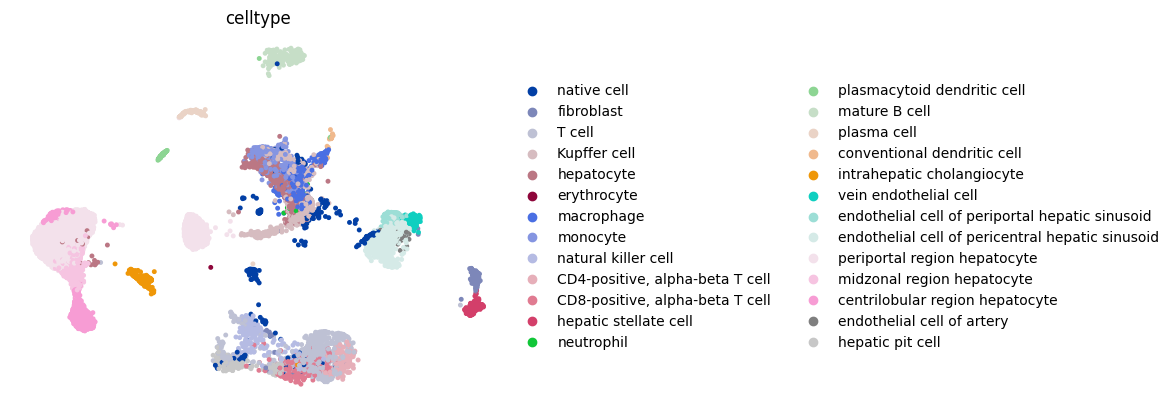

In [418]:
sc.pl.umap(adata_sc_dict['healthy'], color=["celltype"], s=50,frameon=False)

In [427]:
for sample_name in adata_sc_dict:
    adata_sc_dict[sample_name] = adata_sc_dict[sample_name][
        adata_sc_dict[sample_name].obs.loc[adata_sc_dict[sample_name].obs.celltype.isin(
            adata_dict[sample_name].obs.celltype)].index,
        :
    ].copy()

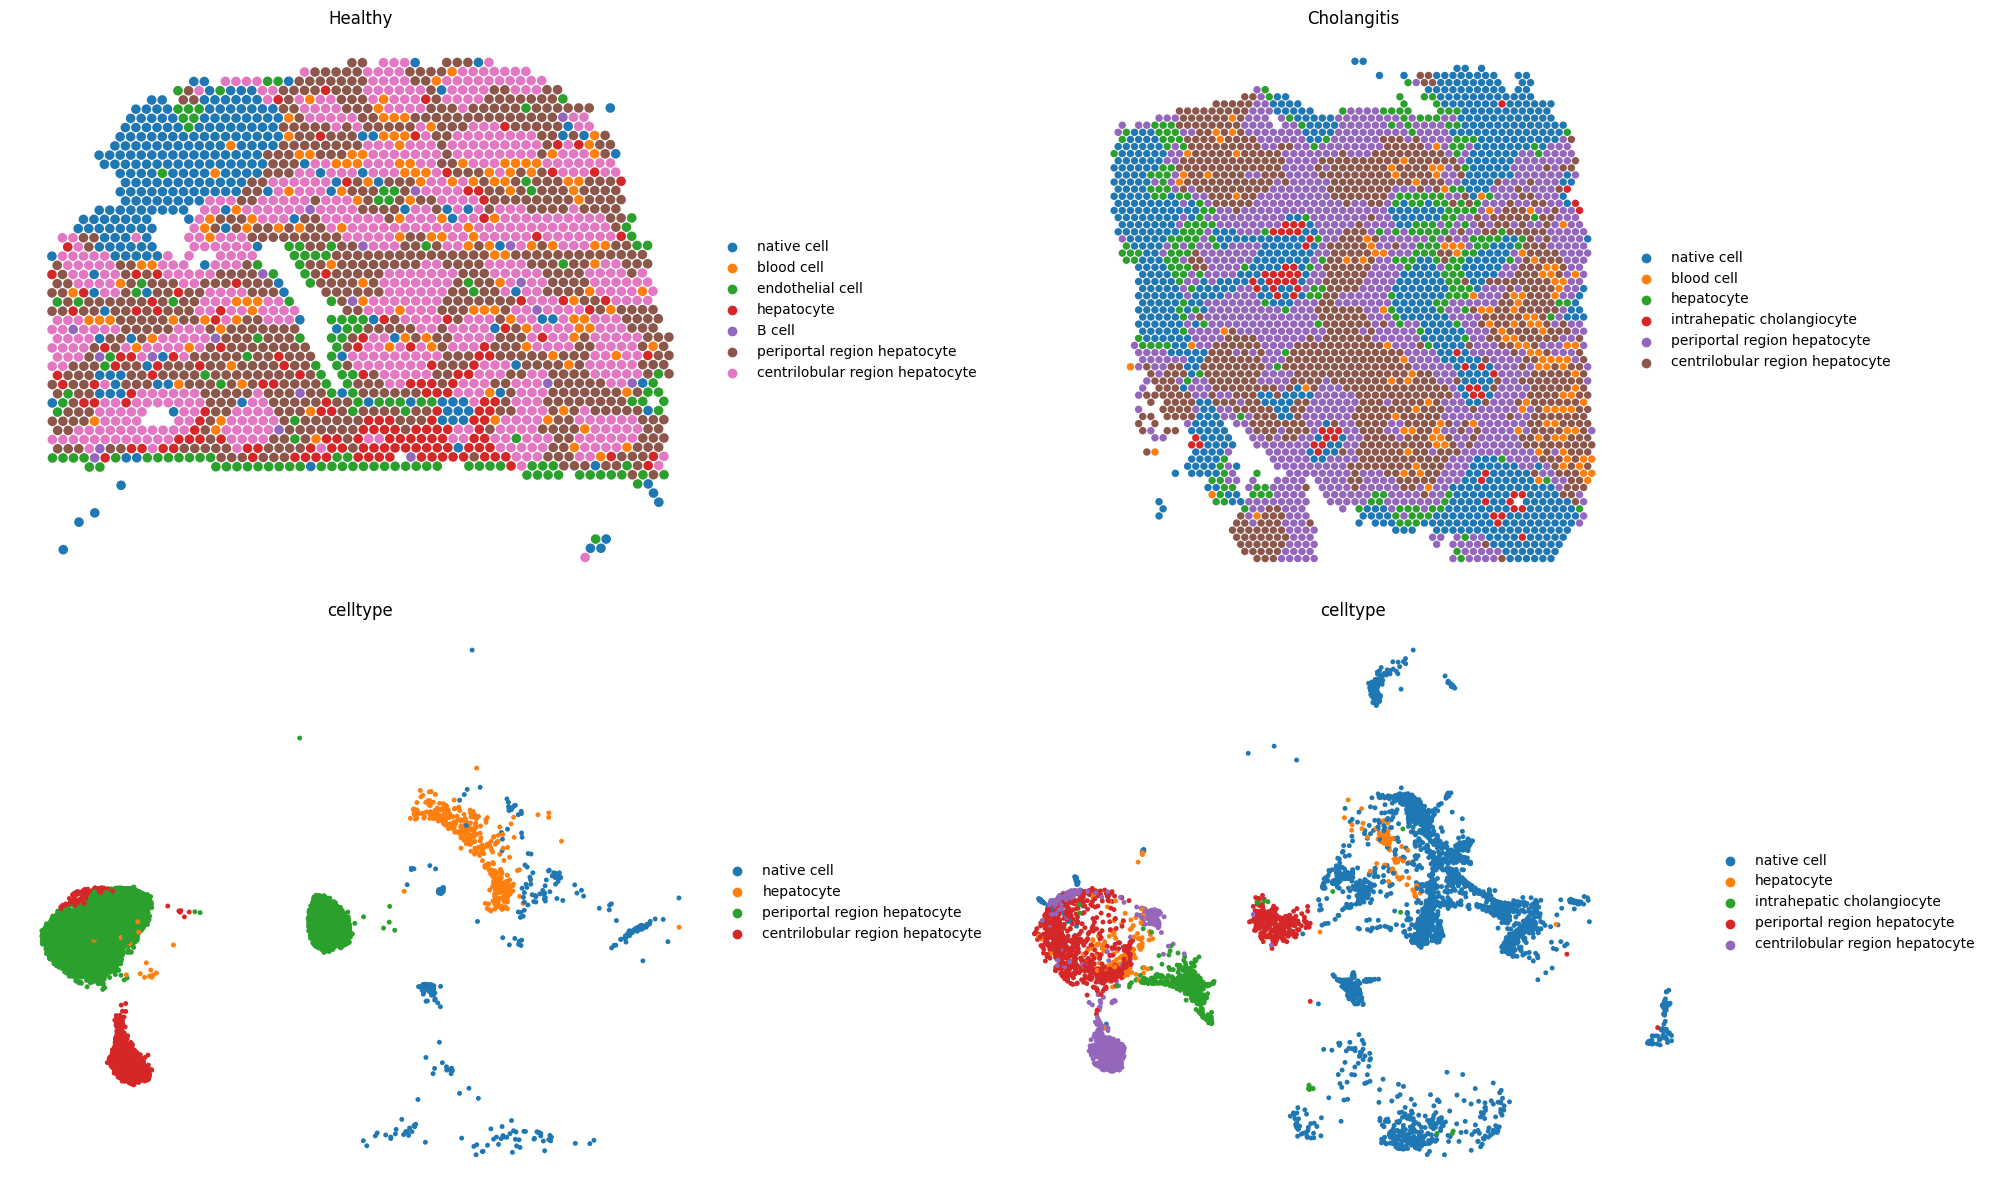

In [430]:
fig, ax = plt.subplots(2,2,figsize=(20,12))
sc.pl.spatial(adata_dict['healthy'], 
              color='celltype', 
              spot_size=300, 
              img_key=None,
              frameon=False, ax = ax[0,0],show=False,title='Healthy')
sc.pl.spatial(adata_dict['cholangitis'], 
              color='celltype', 
              spot_size=300, 
              img_key=None,
              frameon=False, ax = ax[0,1],show=False,title='Cholangitis')
sc.pl.umap(adata_sc_dict['healthy'], color=["celltype"], s=50,frameon=False,ax=ax[1,0], show=False)
sc.pl.umap(adata_sc_dict['cholangitis'], color=["celltype"], s=50, frameon=False,ax=ax[1,1], show=False)
plt.tight_layout()

In [143]:
def get_spatialdm_lr(species='human', datahost='builtin'):
    if datahost == 'package':
        if species in ['mouse', 'human', 'zerafish']:
            datapath = './datasets/LR_data/%s-' %(species)
        else:
            raise ValueError("species type: {} is not supported currently. Please have a check.".format(species))
        
        import pkg_resources
        stream1 = pkg_resources.resource_stream(__name__, datapath + 'interaction_input_CellChatDB.csv.gz')
        geneInter = pd.read_csv(stream1, index_col=0, compression='gzip')

        stream2 = pkg_resources.resource_stream(__name__, datapath + 'complex_input_CellChatDB.csv')
        comp = pd.read_csv(stream2, header=0, index_col=0)
    else:
        if species == 'mouse':
            geneInter = pd.read_csv('https://figshare.com/ndownloader/files/36638919', index_col=0)
            comp = pd.read_csv('https://figshare.com/ndownloader/files/36638916', header=0, index_col=0)
        elif species == 'human':
            geneInter = pd.read_csv('https://figshare.com/ndownloader/files/36638943', header=0, index_col=0)
            comp = pd.read_csv('https://figshare.com/ndownloader/files/36638940', header=0, index_col=0)
        elif species == 'zebrafish':
            geneInter = pd.read_csv('https://figshare.com/ndownloader/files/38756022', header=0, index_col=0)
            comp = pd.read_csv('https://figshare.com/ndownloader/files/38756019', header=0, index_col=0)
        else:
            raise ValueError("species type: {} is not supported currently. Please have a check.".format(species))
    
    geneInter = geneInter.sort_values('annotation')
    ligand = geneInter.ligand.values
    receptor = geneInter.receptor.values
    geneInter.pop('ligand')
    geneInter.pop('receptor')
    return(geneInter, comp, ligand, receptor)

In [232]:
def copulacci_filter(adata, geneInter, ligand_df, receptor_df, min_cell=3, mean='algebric'):
    if mean=='geometric':
        from scipy.stats.mstats import gmean
    adata.uns['mean'] = mean
    
    # linearize ligands
    ligand_linear = set(list(pd.Series(ligand_df.values.flatten()).dropna().values))
    receptor_linear = set(list(pd.Series(receptor_df.values.flatten()).dropna().values))
    lr_genes = ligand_linear.union(receptor_linear)
    lr_genes = set(adata.var_names).intersection(set(lr_genes))

    count_df_norm = adata.to_df().loc[:, list(lr_genes)].copy()  
    gene_presence_count = (count_df_norm > 0).sum()
    lr_present = gene_presence_count[gene_presence_count > min_cell].index.tolist()
    
    indices_l = ligand_df.apply(lambda row: any(item in lr_present for item in row), axis=1)
    indices_r = receptor_df.apply(lambda row: any(item in lr_present for item in row), axis=1)
    indices_lr = pd.Index(set(ligand_df[indices_l].index).intersection(receptor_df[indices_r].index))
    
    ind = indices_lr
    adata.uns['num_pairs'] = len(ind)
    adata.uns['geneInter'] = geneInter.loc[ind]
    adata.uns['ligand'] = ligand_df.loc[ind]
    adata.uns['receptor'] = receptor_df.loc[ind]
    
    if adata.uns['num_pairs'] == 0:
        raise ValueError("No effective RL. Please have a check on input count matrix/species.")
    return

In [240]:
def extract_lr_list(adata):
    ligand_linear = set(list(pd.Series(adata.uns['ligand'].values.flatten()).dropna().values))
    receptor_linear = set(list(pd.Series(adata.uns['receptor'].values.flatten()).dropna().values))
    lr_genes = ligand_linear.union(receptor_linear)
    lr_genes = list(set(adata.var_names).intersection(set(lr_genes)))
    return lr_genes

In [160]:
geneInter, comp, ligand, receptor = get_spatialdm_lr()

In [161]:
for i in range(len(ligand)):
    for n in [ligand, receptor]:
        l = n[i]
        if l in comp.index:
            n[i] = comp.loc[l].dropna().values
        else:
            n[i] = pd.Series(l).values
ligand_df = pd.DataFrame.from_records(zip_longest(*pd.Series(ligand).values)).transpose()
ligand_df.columns = ['Ligand' + str(i) for i in range(ligand_df.shape[1])]
ligand_df.index = geneInter.index
receptor_df = pd.DataFrame.from_records(zip_longest(*pd.Series(receptor).values)).transpose()
receptor_df.columns = ['Ligand' + str(i) for i in range(receptor_df.shape[1])]
receptor_df.index = geneInter.index

In [431]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if tmp.shape[0] == 0:
            continue
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        if tmp.shape[0] == 0:
            continue 
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df

def get_data_tuple(count_df_lr_ct, lig, rec, summarization = "sum"):
    _lig = [l for l in lig if l is not None]
    _rec = [r for r in rec if r is not None]
    data_tuple = (
        count_df_lr_ct.loc[ :, _lig ].sum(axis=1).values.astype('int'),
        count_df_lr_ct.loc[ :, _rec ].sum(axis=1).values.astype('int')
    )
    return data_tuple

def get_data_tuple_float(count_df_lr_ct, lig, rec, summarization = "sum"):
    _lig = [l for l in lig if l is not None]
    _rec = [r for r in rec if r is not None]
    data_tuple = (
        count_df_lr_ct.loc[ :, _lig ].sum(axis=1).values,
        count_df_lr_ct.loc[ :, _rec ].sum(axis=1).values
    )
    return data_tuple

In [433]:
copula_results = {}
for sample_name in adata_sc_dict:
    adata = adata_sc_dict[sample_name]
    copulacci_filter(
        adata,
        geneInter,
        ligand_df,
        receptor_df,
        min_cell=20
    )
    lr_list = extract_lr_list(adata)
    count_df = adata.raw.to_adata().to_df()
    count_df.columns = adata.to_df().columns

    print("prepare for copula run and normalized matrices for other runs")
    count_df_lr = count_df.loc[:, lr_list].astype('int')
    count_df_norm = count_df.div(count_df.sum(1), axis = 0) 
    count_df_norm_log = np.log( count_df_norm + 1 )

    data_list_dict = {}
    data_list_log_norm_dict = {}
    umi_list_dict = {}
    lig_df = adata.uns['ligand']
    rec_df = adata.uns['receptor']
    ct_to_run = adata.obs.groupby('celltype')['donor_id'].count()[
    adata.obs.groupby('celltype')['donor_id'].count() > 50].index.tolist()
    for celltype in tqdm.tqdm(ct_to_run):
        data_list = []
        data_list_norm = []
        cell_ids = adata.obs.loc[adata.obs.celltype == celltype].index
        
        count_df_lr_ct = count_df_lr.loc[cell_ids,:].copy()
        count_df_norm_log_ct = count_df_norm_log.loc[cell_ids,:].copy()
        
        umi_list_dict[celltype] = count_df_lr_ct.sum(1).values
        for index, row in adata.uns['geneInter'].iterrows():
            lig = lig_df.loc[index].values.tolist()
            rec = rec_df.loc[index].values.tolist()
            data_list += [
                get_data_tuple(
                    count_df_lr_ct,
                    lig,
                    rec
                )
            ]
            data_list_norm += [
                get_data_tuple_float(
                    count_df_norm_log_ct,
                    lig,
                    rec
                )
            ]
        data_list_dict[celltype] = data_list.copy()
        data_list_log_norm_dict[celltype] = data_list_norm.copy()

    copula_params = model2.CopulaParams()
    opt_params = model2.OptParams()
    
    copula_df = {}
    for ct in tqdm.tqdm(ct_to_run):
        _n_array = umi_list_dict[ct]
        data_list = data_list_dict[ct]
        data_list_norm = data_list_log_norm_dict[ct]
        opt_res = Parallel(n_jobs=20, verbose=0)(
            delayed(model2.call_optimizer)(
                data_list[i][0],
                data_list[i][1],
                _n_array,
                _n_array,
                copula_params,
                opt_params,
                stability_filter=True,
                quick=True,
                run_find_peaks = True
            ) for i in range(len(data_list))
        )
        spr = Parallel(n_jobs=20, verbose=0)(
            delayed(stats.spearmanr)(
                x,
                y
            ) for (x,y) in data_list_norm
        )
        prs = Parallel(n_jobs=20, verbose=0)(
            delayed(stats.pearsonr)(
                x,
                y
            ) for (x,y) in data_list_norm
        )
    
        spr = [s.correlation for s in spr]
        prs = [s.correlation for s in prs]
        cop_df = pd.DataFrame(opt_res, columns=['cop','mu_x', 'mu_y', 'copula_method'])
        cop_df.loc[:,'spearman_log'] = spr
        cop_df.loc[:,'pearson_log'] = prs
        cop_df.index = adata.uns['ligand'].index
        copula_df[ct] = cop_df.copy()

    copulacci_sc_df = linearize_to_df(copula_df)
    copula_results[sample_name] = copulacci_sc_df.copy()

prepare for copula run and normalized matrices for other runs


  0%|          | 0/5 [00:00<?, ?it/s]/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(

prepare for copula run and normalized matrices for other runs


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


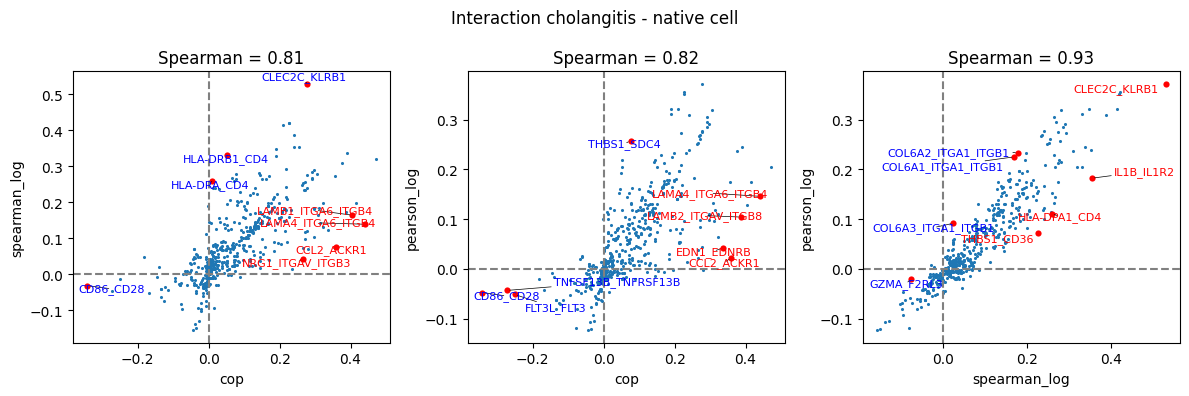

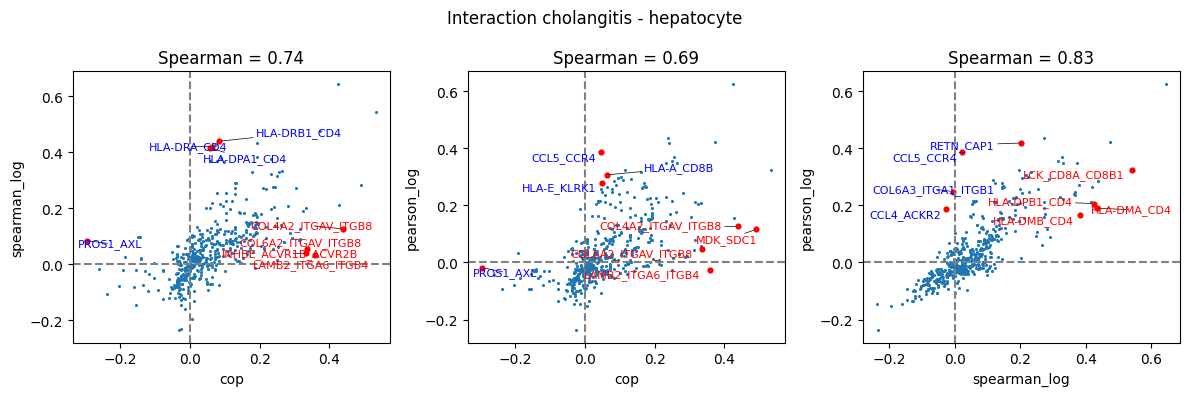

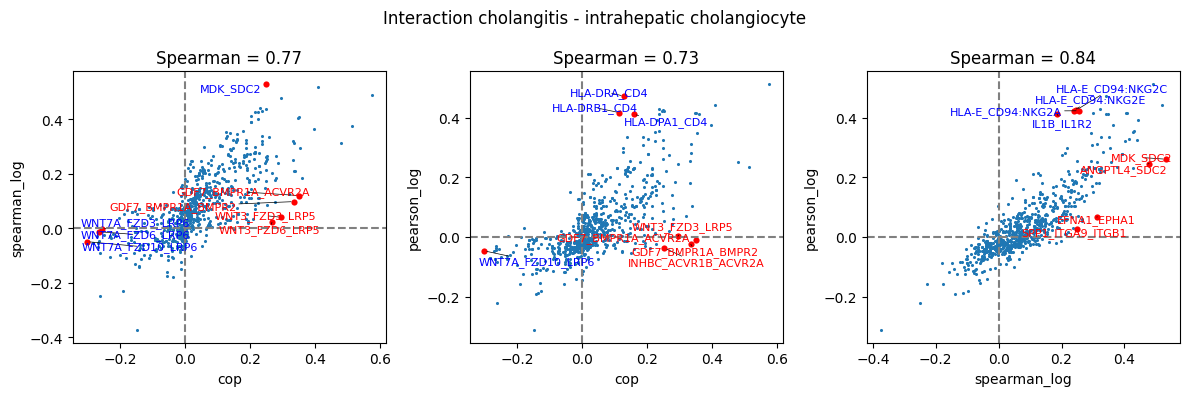

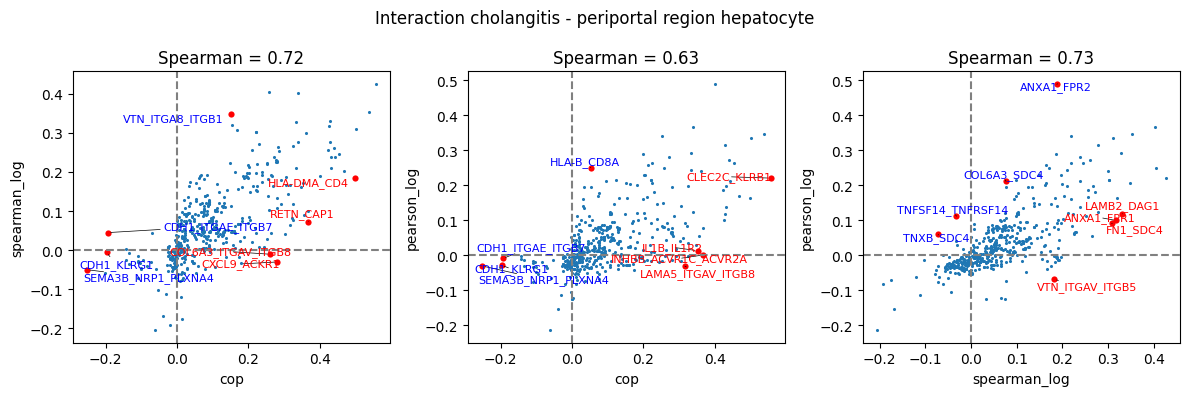

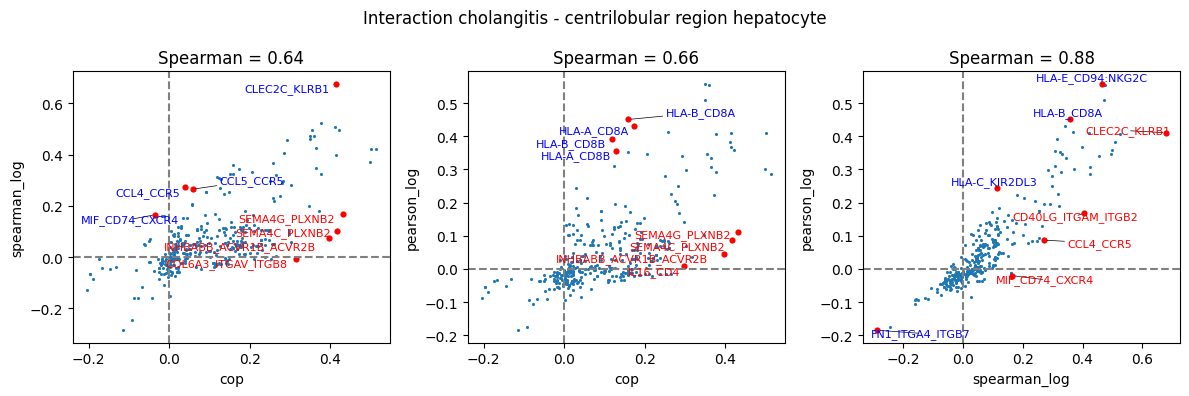

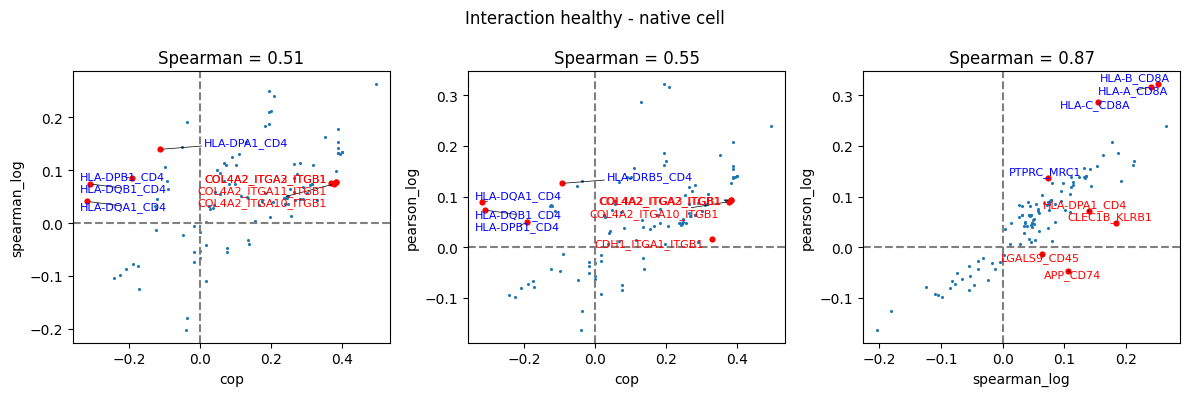

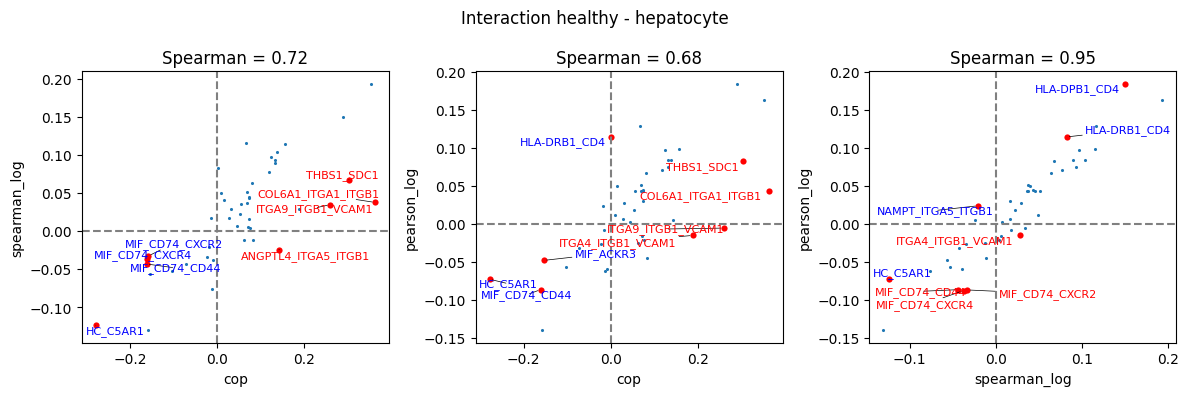

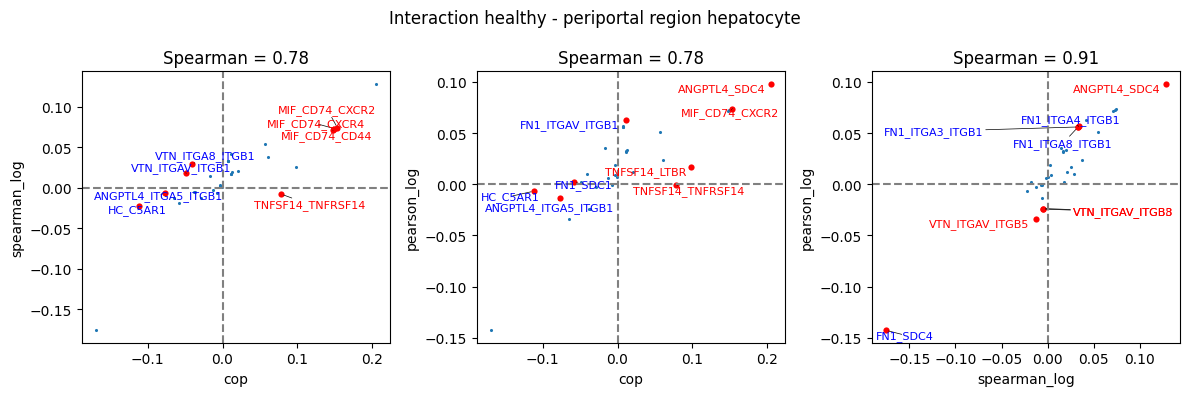

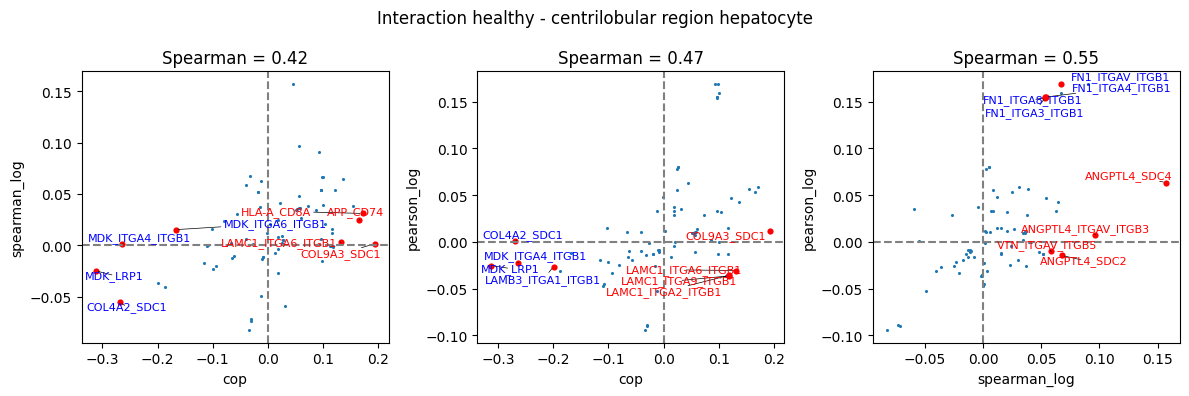

In [435]:
from copulacci import plots2
for sample_name in copula_results:
    copulacci_sc_df = copula_results[sample_name]
    for ct in copulacci_sc_df.interaction.unique():
        res = copulacci_sc_df.loc[copulacci_sc_df.interaction == ct].copy()
        plots2.draw_pairwise_scatter(
            res.set_index('LR_index'),
            sample_name + " - " + ct,
            score_pair,
            bimod_filter=False,
            s = 5,
            ntop=4,
            center_plot=False,
            take_diff=True
            #only_pos=True
        )

In [243]:
lr_list = extract_lr_list(adata)

In [248]:
count_df = adata.raw.to_adata().to_df()
count_df.columns = adata.to_df().columns

In [258]:
count_df_lr = count_df.loc[:, lr_list].astype('int')

In [262]:
count_df_lr.shape

(24241, 483)

## Compare Single-cell vs Visium results (Cholangitis)

In [544]:
sample_name = 'cholangitis'

In [545]:
copulacci_sc_df = copula_results[sample_name].copy()

In [546]:
adata_sc = adata_sc_dict[sample_name].copy()
adata_st = adata_dict[sample_name].copy()

In [547]:
def show_differnce(
    res,
    ntop,
    x_col,
    y_col,
    take_diff = False,
    take_sim = False,
    pval_cutoff = None,
):
    if pval_cutoff is not None:
            res = res.loc[res.copula_pval_fdr < pval_cutoff].copy()
    if take_sim:
            
        res['Rank1'] = res[x_col].abs().rank(method='dense', ascending=False)
        res['Rank2'] = res[y_col].abs().rank(method='dense', ascending=False)
        intersection_dict = {}
        len_dict = {}
        for ind in range(res.shape[0]):
            lr_intersect = set(res.sort_values('Rank1').index[:ind]).intersection(
                set(res.sort_values('Rank2').index[:ind])
            )
            intersection_dict[ind] = lr_intersect
            len_dict[len(lr_intersect)] = ind
        top_index_key = []
        if ntop in len_dict:
            top_index_key = len_dict[ntop]
        else:
            for k in len_dict:
                if k > ntop:
                    top_index_key = len_dict[k]
                    break
        sig1 = res.loc[list(intersection_dict[top_index_key])].loc[res[x_col] > 0].copy()
        return sig1
    res['diff1'] = res[x_col] - res[y_col]
    res['diff2'] = res[y_col] - res[x_col]
    sig1 = res.sort_values('diff1', ascending=False)[:ntop]
    # sig2 = res.sort_values('diff2', ascending=False)[:ntop]
    return sig1

In [529]:
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

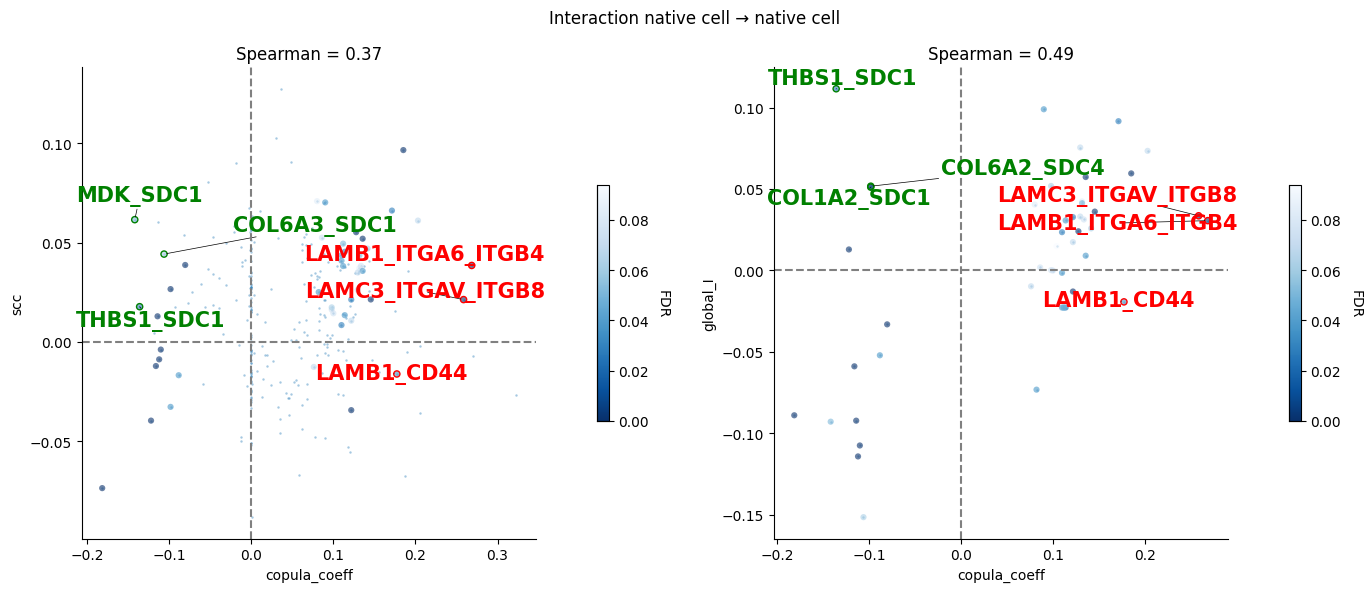

In [595]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'native cell=native cell',
    score_pair[:2],
    ntop=3,
    center_plot=False,
    take_diff=True,
    fig_size = (14,6),
    force_text_pos=(1,0.1),
    use_cutoff=True,
    fontsize_small=15
)

In [592]:
importlib.reload(plots2)

<module 'copulacci.plots2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/plots2.py'>

In [ ]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'native cell=native cell',
    score_pair[:2],
    ntop=3,
    center_plot=False,
    take_diff=True,
    fig_size = (14,6),
    force_text_pos=(1,0.1),
    use_cutoff=True
)

In [585]:
sig = show_differnce(
    merged_res_dict['native cell=native cell'].copy(),
    ntop=10,
    x_col='copula_coeff',
    y_col='scc',
    take_diff = True,
    take_sim = False,
    pval_cutoff=0.1
)

In [586]:
sig

copula_coeff       mu_x       mu_y copula_method  \
LAMC3_ITGAV_ITGB8        0.258649 -10.103347  -9.470943        copula   
LAMB1_ITGA6_ITGB4        0.268559  -9.362859 -10.272824        copula   
LAMB1_CD44               0.177387  -9.362859  -9.814715        copula   
COL6A3_CD44              0.121892  -9.205476  -9.814715        copula   
IGF1_ITGAV_ITGB3         0.203153  -9.360143  -9.520643        copula   
TGFB1_ACVR1C_TGFBR2      0.145676  -9.737965  -8.934982        copula   
LAMB1_ITGA6_ITGB1        0.121892  -9.362859  -8.059217        copula   
COL6A3_ITGAV_ITGB8       0.171441  -9.205476  -9.470943        copula   
CXCL12_CXCR4             0.129820  -8.942695  -9.363766        copula   
TGFB1_ACVR1_TGFBR1       0.110000  -9.737965  -8.673800        copula   

                     copula_pval       scc  scc_pval  global_I  global_pval  \
LAMC3_ITGAV_ITGB8       0.000000  0.021286  0.493014  0.033522     0.345867   
LAMB1_ITGA6_ITGB4       0.000000  0.038470  0.177645  0.030543     0.371419   
LAMB1_CD44              0.003992 -0.016161  0.500998 -0.019353     1.000000   
COL6A3_CD44             0.000000 -0.034372  0.175649 -0.012991     1.000000   
IGF1_ITGAV_ITGB3        0.009980  0.061060  0.041916  0.073410     0.028531   
TGFB1_ACVR1C_TGFBR2     0.000000  0.021344  0.471058  0.036090     0.313907   
LAMB1_ITGA6_ITGB1       0.009980  0.010654  0.688623  0.017344     0.636948   
COL6A3_ITGAV_ITGB8      0.001996  0.066089  0.017964  0.091631     0.003069   
CXCL12_CXCR4            0.009980  0.026139  0.351297  0.033052     0.350359   
TGFB1_ACVR1_TGFBR1      0.001996  0.008454  0.734531  0.023467     0.491580   

                     copula_pval_fdr     diff1     diff2  
LAMC3_ITGAV_ITGB8           0.000000  0.237362 -0.237362  
LAMB1_ITGA6_ITGB4           0.000000  0.230089 -0.230089  
LAMB1_CD44                  0.037525  0.193549 -0.193549  
COL6A3_CD44                 0.000000  0.156264 -0.156264  
IGF1_ITGAV_ITGB3            0.068643  0.142093 -0.142093  
TGFB1_ACVR1C_TGFBR2         0.000000  0.124332 -0.124332  
LAMB1_ITGA6_ITGB1           0.068643  0.111238 -0.111238  
COL6A3_ITGAV_ITGB8          0.028144  0.105353 -0.105353  
CXCL12_CXCR4                0.068643  0.103681 -0.103681  
TGFB1_ACVR1_TGFBR1          0.028144  0.101546 -0.101546

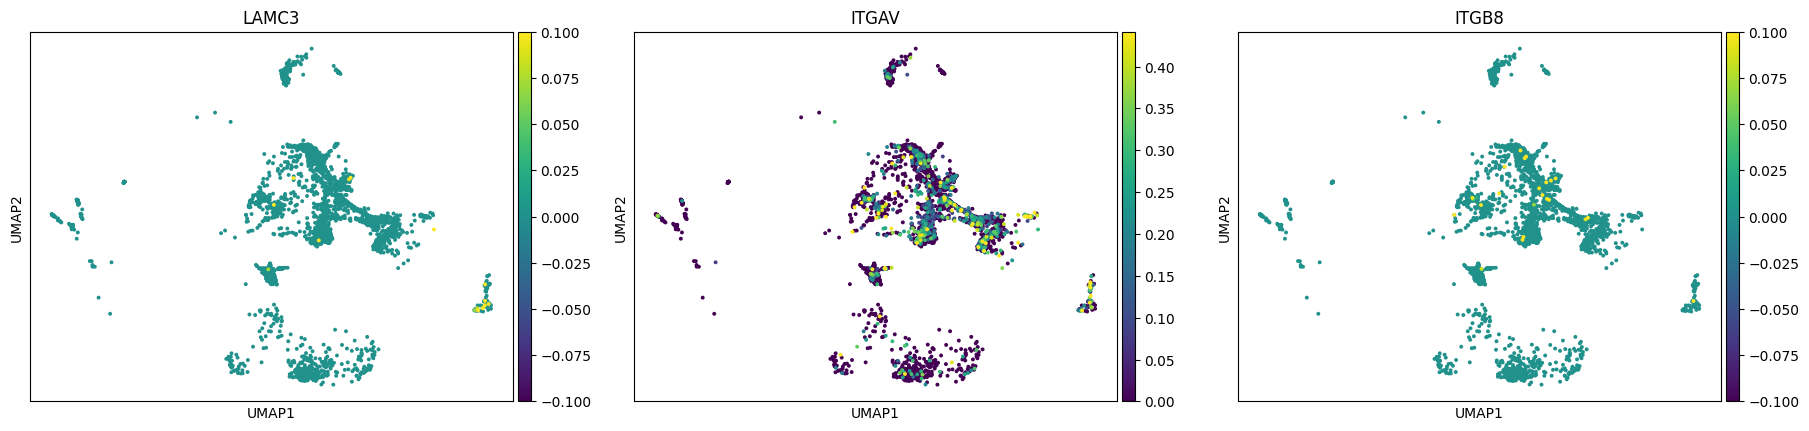

In [550]:
sc.pl.umap(adata_sc[adata_sc.obs.celltype == 'native cell',:], 
           color=["LAMC3", "ITGAV", "ITGB8"],
           use_raw=False,vmax="p99")

In [571]:
from adjustText import adjust_text

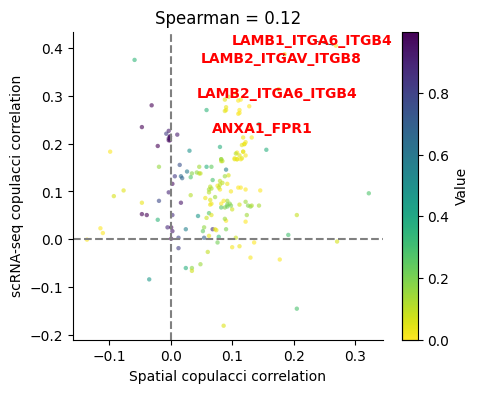

In [597]:
df1 = merged_res_dict['native cell=native cell'][['copula_coeff', 'copula_pval','copula_method']]
df1 = df1.loc[df1.copula_method == 'copula']
df2 = copulacci_sc_df.loc[copulacci_sc_df.interaction == 'native cell'][['cop',
                                                                       'LR_index']].set_index('LR_index')
df = df1.join(df2,how='inner')
df.receptor
y_col = 'cop'
x_col = 'copula_coeff'
ntop = 4

df['Rank1'] = df[x_col].abs().rank(method='dense', ascending=False)
df['Rank2'] = df[y_col].abs().rank(method='dense', ascending=False)
intersection_dict = {}
len_dict = {}
for ind in range(res.shape[0]):
    lr_intersect = set(df.sort_values('Rank1').index[:ind]).intersection(
        set(df.sort_values('Rank2').index[:ind])
    )
    intersection_dict[ind] = lr_intersect
    len_dict[len(lr_intersect)] = ind
top_index_key = []
if ntop in len_dict:
    top_index_key = len_dict[ntop]
else:
    for k in len_dict:
        if k >= ntop:
            top_index_key = len_dict[k]
            break


sig1 = df.loc[list(intersection_dict[top_index_key])].loc[df[x_col] > 0].copy()

fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=df,x = 'copula_coeff', y = 'cop', hue = 'copula_pval',s=10,alpha=0.6, 
                linewidth=0,palette='viridis_r',legend=False,ax=ax)

text_sig = []
for j,r in sig1.iterrows():
    text_sig.append(
        ax.text(
            x=r[x_col],
            y = r[y_col],
            s = j,
            color = (1, 0, 0),
            fontsize = 10,
            weight='bold'
        )
    )
adjust_text(
    text_sig,
    ensure_inside_axes = True,
    expand_axes = True,
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
    ax=ax
)

norm = plt.Normalize(df['copula_pval'].min(), df['copula_pval'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax, label='Value')
ax.set_xlabel('Spatial copulacci correlation')
ax.set_ylabel('scRNA-seq copulacci correlation');
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')
ax.set_title(f'Spearman = {stats.spearmanr(df["cop"].values,  df["copula_coeff"].values)[0] :.2f}'
        )
sns.despine()
plt.show()

In [598]:
copulacci_st_df = linearize_to_df(merged_res_dict)

In [599]:
copulacci_st_df.to_csv('copulacci_st.csv')

In [569]:
df.loc[list(set(df.index).intersection(sig.index))]

copula_coeff  copula_pval copula_method       cop
TGFB1_ACVR1_TGFBR1       0.110000     0.001996        copula  0.108018
LAMB1_ITGA6_ITGB1        0.121892     0.009980        copula  0.175405
LAMB1_CD44               0.177387     0.003992        copula -0.042613
CXCL12_CXCR4             0.129820     0.009980        copula -0.038649
COL6A3_CD44              0.121892     0.000000        copula  0.036667
LAMB1_ITGA6_ITGB4        0.268559     0.000000        copula  0.405315
TGFB1_ACVR1C_TGFBR2      0.145676     0.000000        copula  0.102072

In [496]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

# Prepare the output
output_notebook()

# Generating sample data
# Creating a ColumnDataSource
source = ColumnDataSource(df)

# Creating the figure
p = figure(tools="", title="Scatter Plot with Index on Hover")

# Adding scatter points
p.circle('copula_coeff', 'cop', size=5, alpha=0.5, source=source)

# Adding hover tool
hover = HoverTool()
hover.tooltips = [("Index", "@index")]
p.add_tools(hover)

# Show the plot
show(p)


Loading BokehJS ...

In [498]:
df.loc['ANGPTL4_ITGAV_ITGB3']

copula_coeff    -0.002973
copula_pval      0.916168
copula_method      copula
cop              0.226937
Name: ANGPTL4_ITGAV_ITGB3, dtype: object

<Axes: xlabel='copula_coeff', ylabel='cop'>

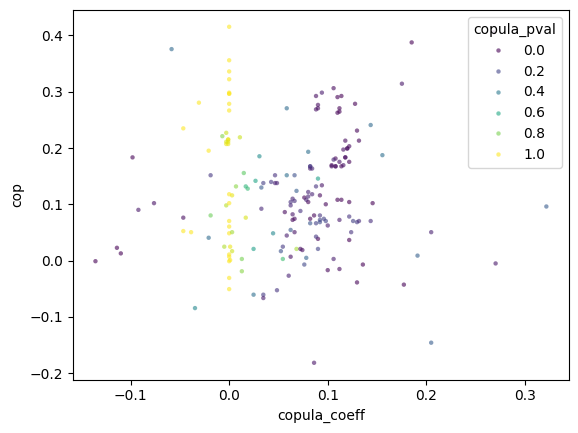

In [454]:
df = copulacci_spatial_res['native cell=native cell'][['copula_coeff', 'copula_pval']].join(
    copulacci_sc_df.loc[copulacci_sc_df.interaction == 'native cell'][['cop', 'LR_index']].set_index('LR_index')
)
sns.scatterplot(data=df,x = 'copula_coeff', y = 'cop', hue = 'copula_pval',s=10,alpha=0.6, 
                linewidth=0,palette='viridis')

In [333]:
data_list_dict = {}
data_list_log_norm_dict = {}
umi_list_dict = {}
lig_df = adata.uns['ligand']
rec_df = adata.uns['receptor']
for celltype in tqdm.tqdm(adata.obs.celltype.unique()):
    data_list = []
    data_list_norm = []
    cell_ids = adata.obs.loc[adata.obs.celltype == celltype].index
    
    count_df_lr_ct = count_df_lr.loc[cell_ids,:].copy()
    count_df_norm_log_ct = count_df_norm_log.loc[cell_ids,:].copy()
    
    umi_list_dict[celltype] = count_df_lr_ct.sum(1).values
    for index, row in adata.uns['geneInter'].iterrows():
        lig = lig_df.loc[index].values.tolist()
        rec = rec_df.loc[index].values.tolist()
        data_list += [
            get_data_tuple(
                count_df_lr_ct,
                lig,
                rec
            )
        ]
        data_list_norm += [
            get_data_tuple_float(
                count_df_norm_log_ct,
                lig,
                rec
            )
        ]
    data_list_dict[celltype] = data_list.copy()
    data_list_log_norm_dict[celltype] = data_list_norm.copy()

100%|██████████| 26/26 [01:29<00:00,  3.45s/it]


21

In [351]:
ct_to_run = adata.obs.groupby('celltype')['donor_id'].count()[
    adata.obs.groupby('celltype')['donor_id'].count() > 100].index.tolist()

['native cell',
 'fibroblast',
 'T cell',
 'Kupffer cell',
 'hepatocyte',
 'macrophage',
 'monocyte',
 'natural killer cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'hepatic stellate cell',
 'plasmacytoid dendritic cell',
 'mature B cell',
 'plasma cell',
 'intrahepatic cholangiocyte',
 'endothelial cell of periportal hepatic sinusoid',
 'endothelial cell of pericentral hepatic sinusoid',
 'periportal region hepatocyte',
 'midzonal region hepatocyte',
 'centrilobular region hepatocyte',
 'hepatic pit cell']

In [324]:
celltype = 'centrilobular region hepatocyte'
cell_ids = adata.obs.loc[adata.obs.celltype == celltype].index
count_df_lr_ct = count_df_lr.loc[cell_ids,:].copy()
count_df_norm_log_ct = count_df_norm_log.loc[cell_ids,:].copy()

In [290]:
#umi_list_dict['periportal region hepatocyte']
from scipy import stats

In [353]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()

copula_df = {}
for ct in tqdm.tqdm(ct_to_run):
    _n_array = umi_list_dict[ct]
    data_list = data_list_dict[ct]
    data_list_norm = data_list_log_norm_dict[ct]
    opt_res = Parallel(n_jobs=20, verbose=0)(
        delayed(model2.call_optimizer)(
            data_list[i][0],
            data_list[i][1],
            _n_array,
            _n_array,
            copula_params,
            opt_params,
            stability_filter=True,
            quick=True,
            run_find_peaks = True
        ) for i in range(len(data_list))
    )
    spr = Parallel(n_jobs=20, verbose=0)(
        delayed(stats.spearmanr)(
            x,
            y
        ) for (x,y) in data_list_norm
    )
    prs = Parallel(n_jobs=20, verbose=0)(
        delayed(stats.pearsonr)(
            x,
            y
        ) for (x,y) in data_list_norm
    )

    spr = [s.correlation for s in spr]
    prs = [s.correlation for s in prs]
    cop_df = pd.DataFrame(opt_res, columns=['cop','mu_x', 'mu_y', 'copula_method'])
    cop_df.loc[:,'spearman_log'] = spr
    cop_df.loc[:,'pearson_log'] = prs
    cop_df.index = adata.uns['ligand'].index
    copula_df[ct] = cop_df.copy()

  0%|          | 0/21 [00:00<?, ?it/s]/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/joblib/parallel.py:589: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func

In [355]:
copulacci_sc_df = linearize_to_df(copula_df)

In [364]:
import itertools
score_pair = list(itertools.combinations(['cop', 'spearman_log','pearson_log'],2))

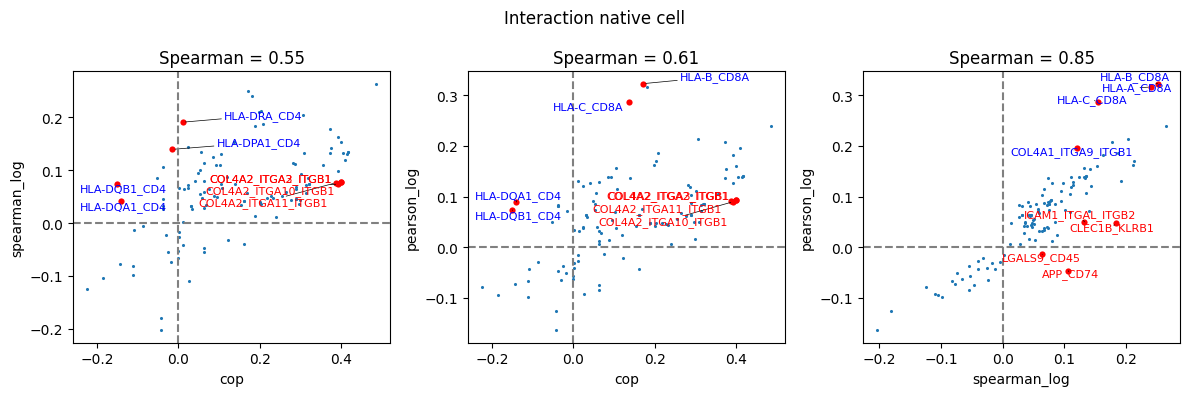

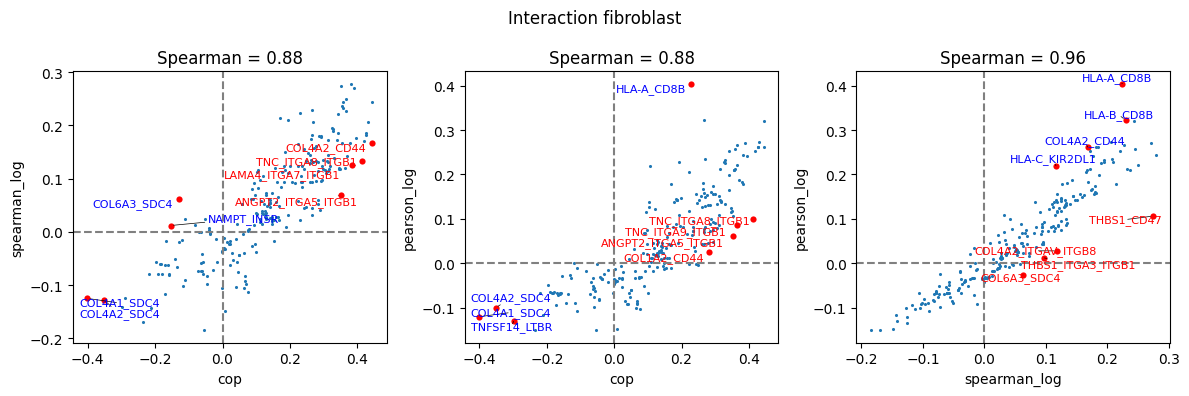

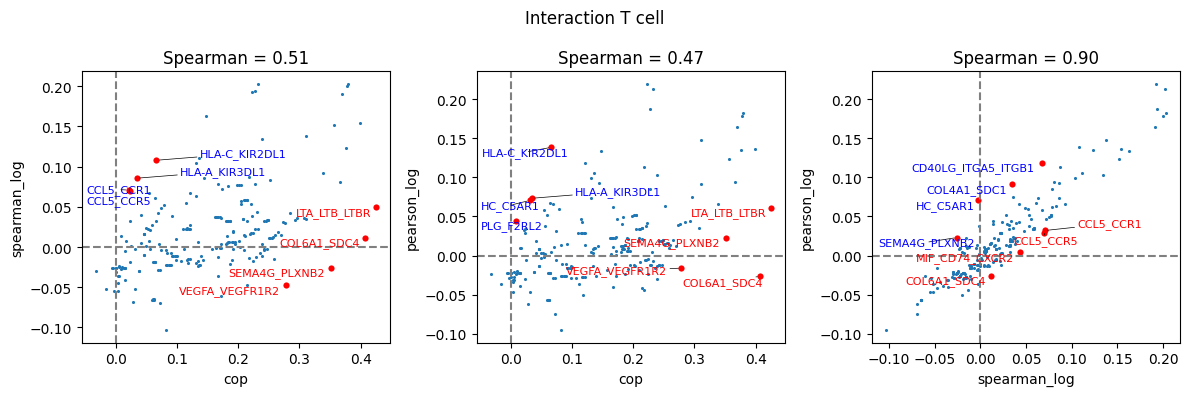

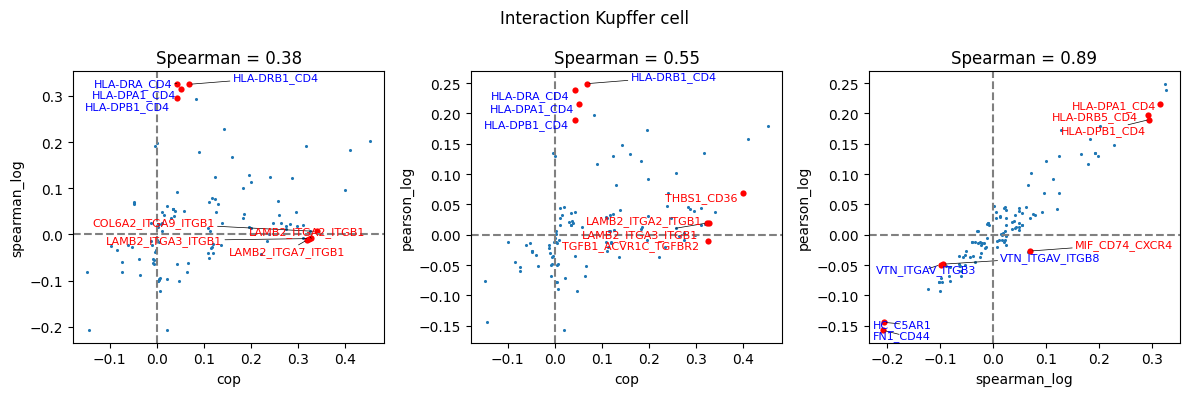

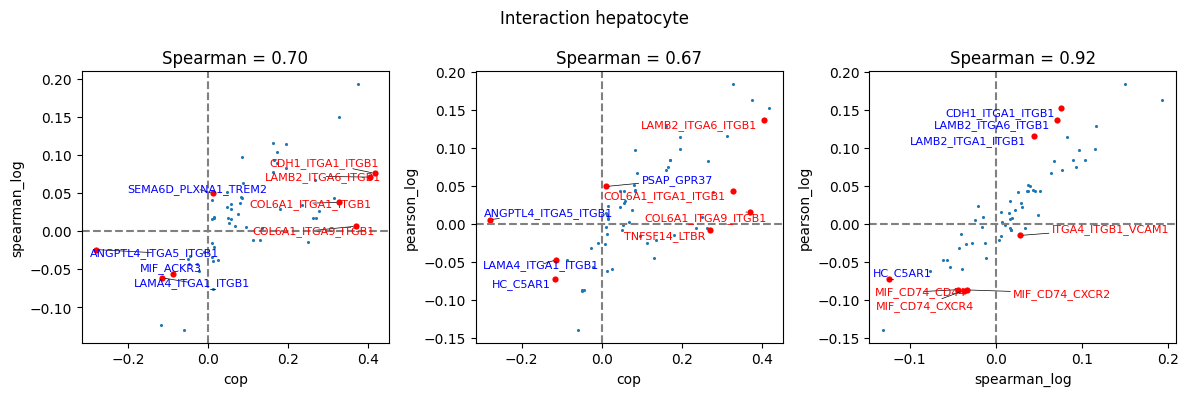

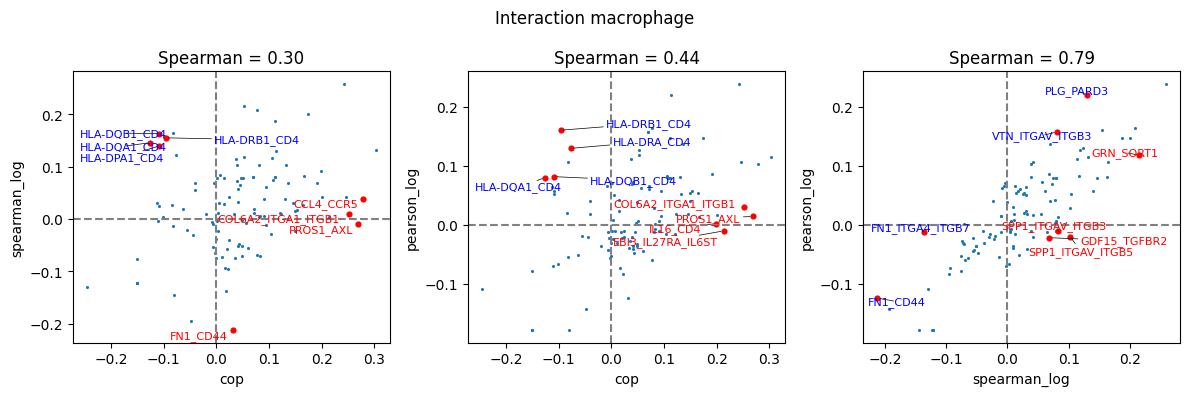

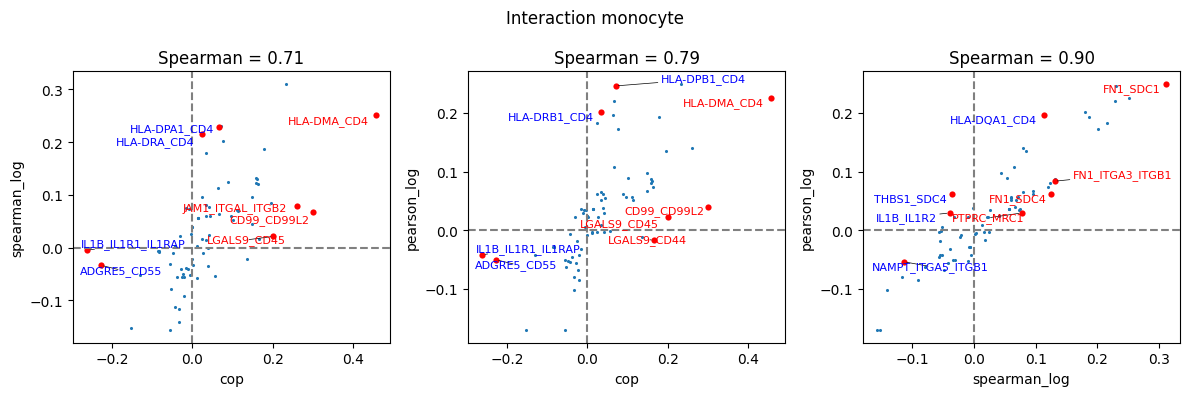

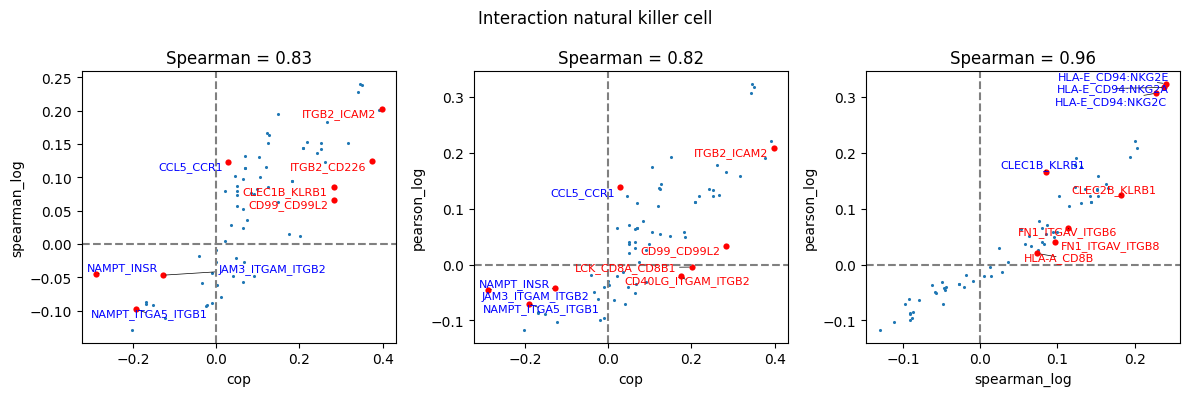

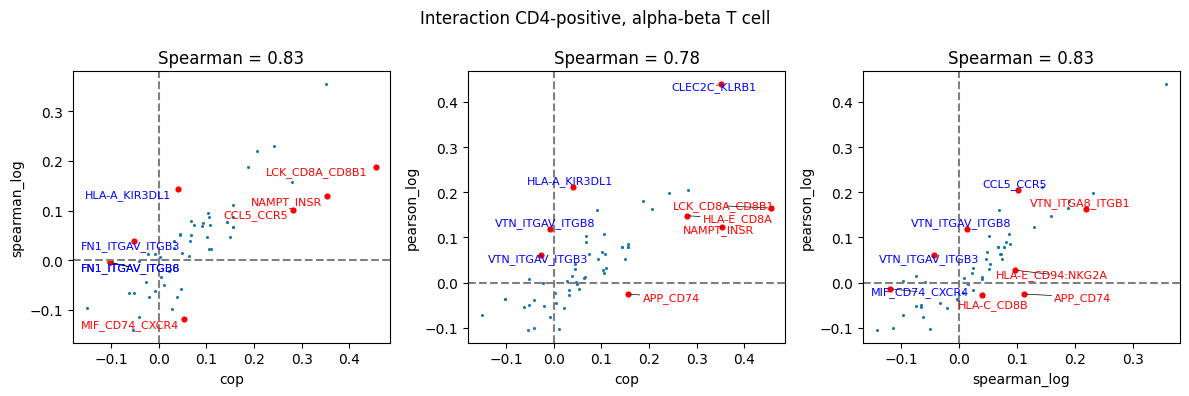

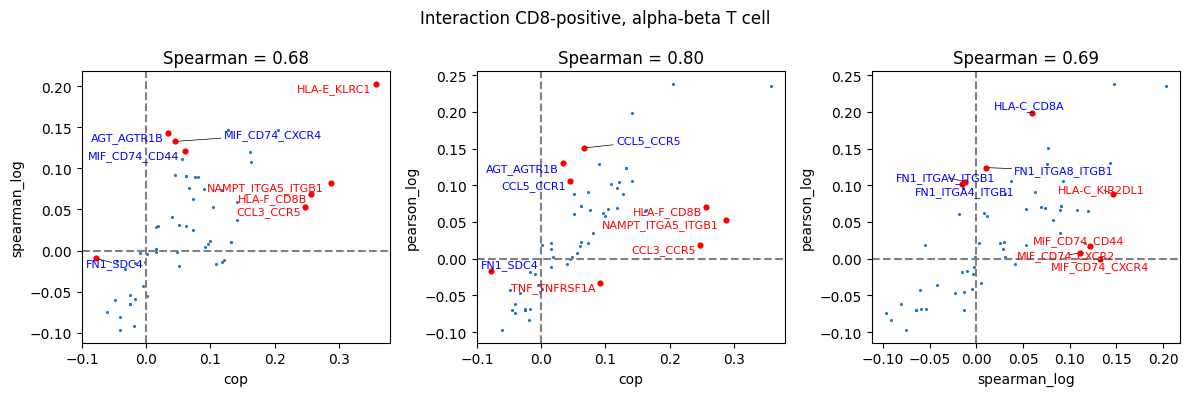

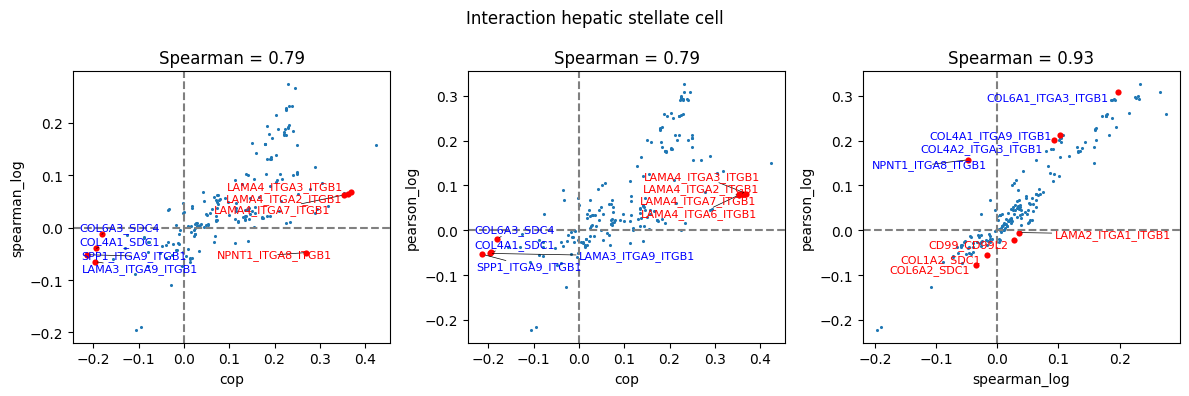

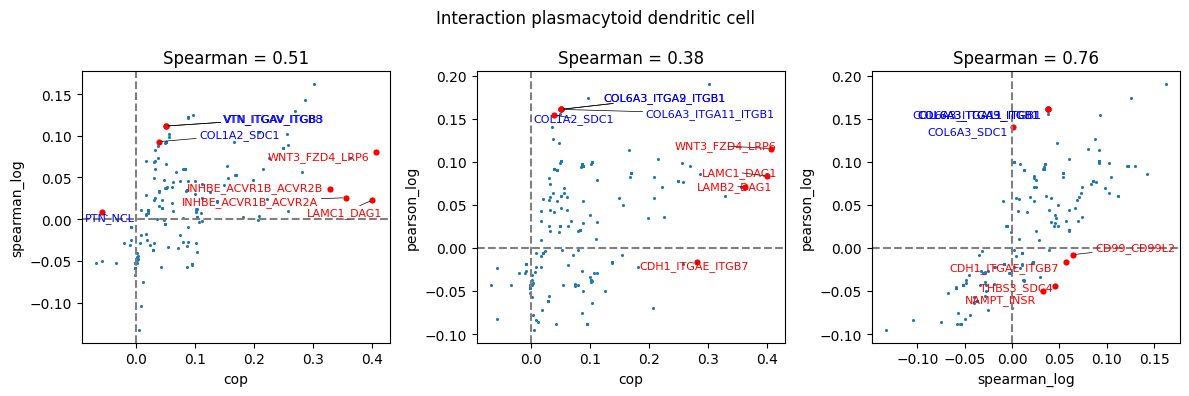

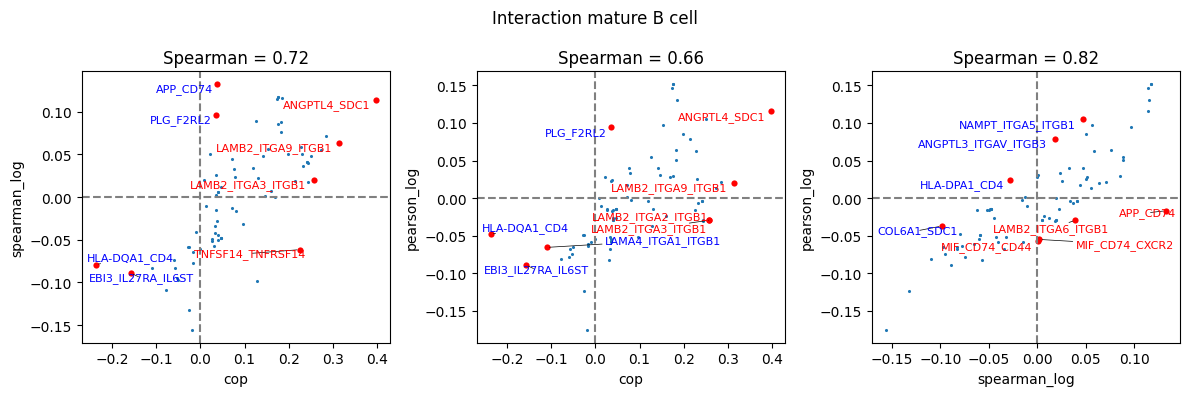

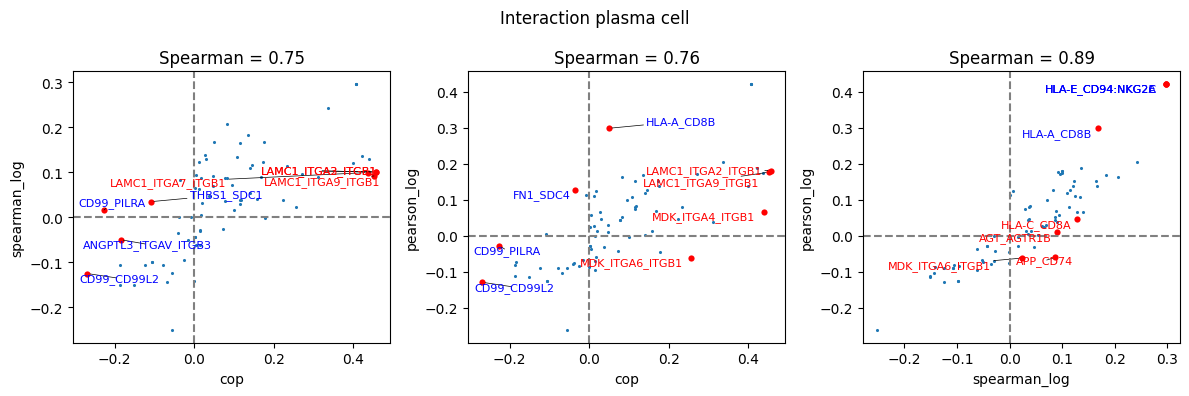

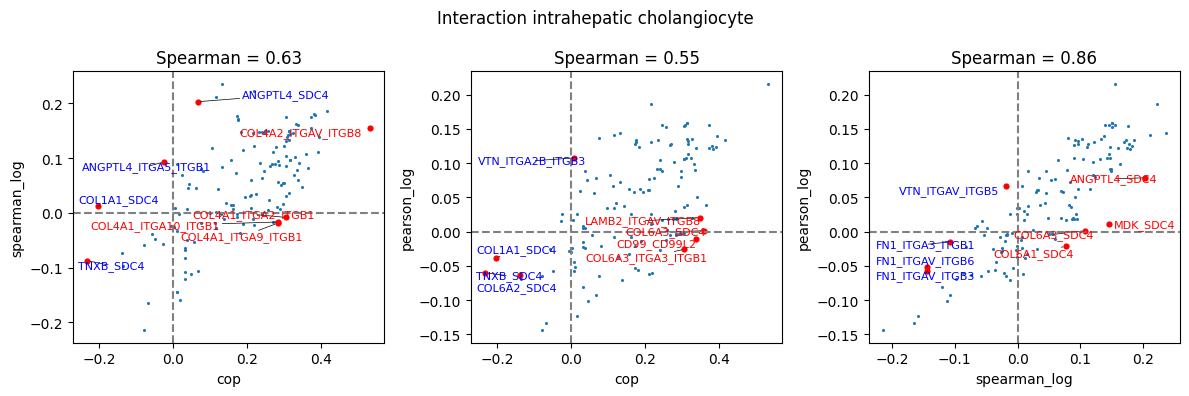

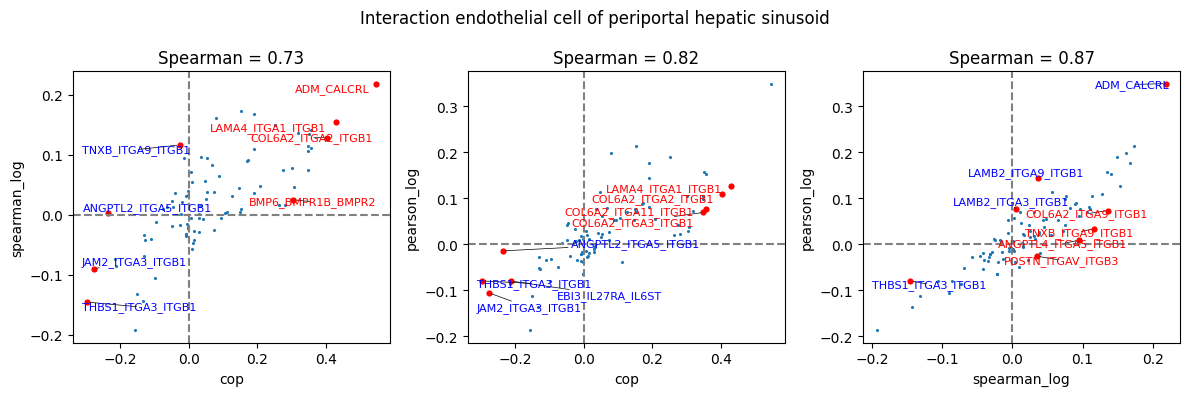

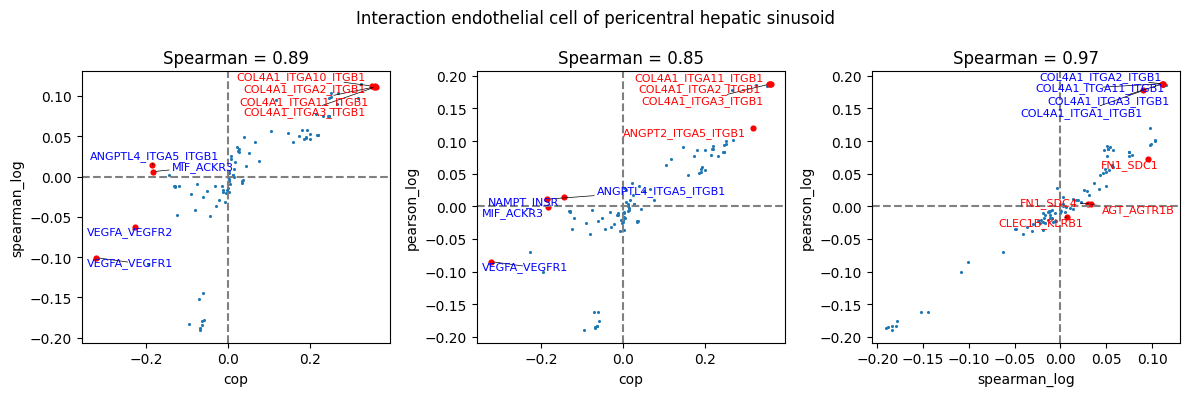

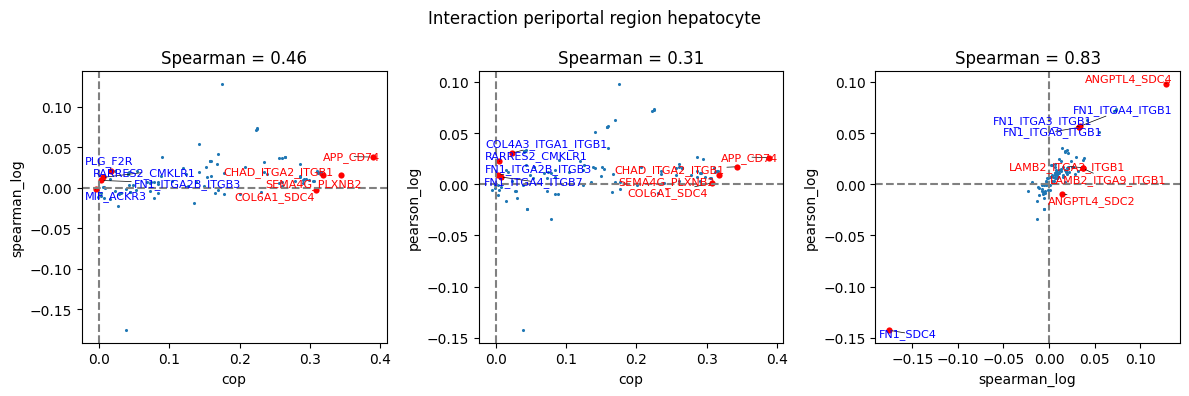

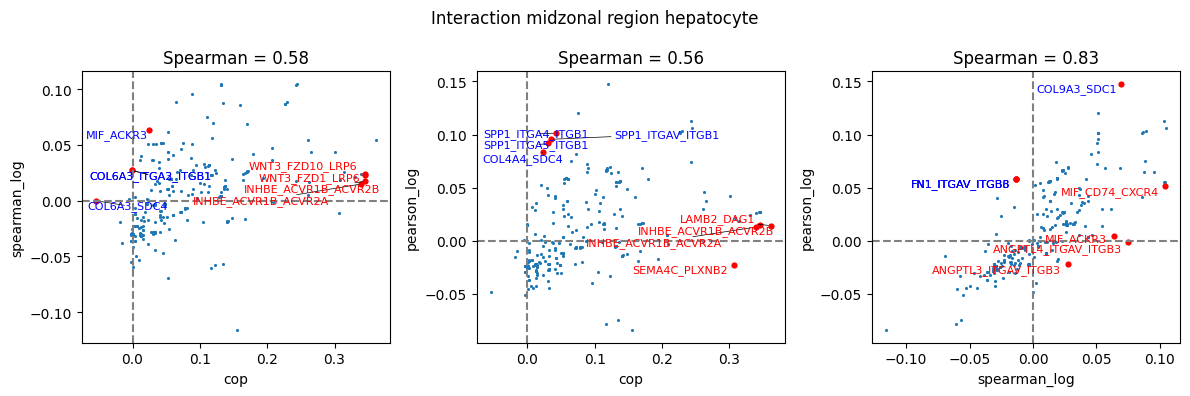

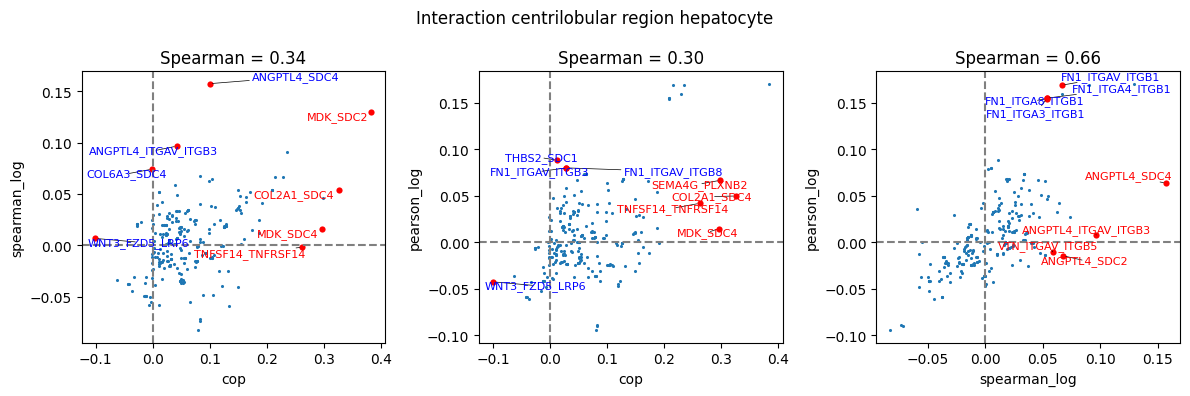

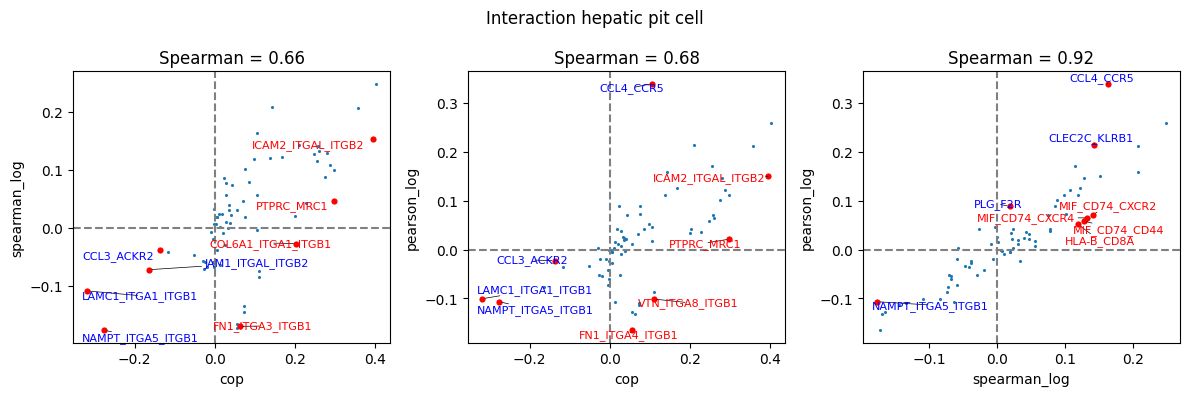

In [389]:
from copulacci import plots2
for ct in copulacci_sc_df.interaction.unique():
    res = copulacci_sc_df.loc[copulacci_sc_df.interaction == ct].copy()
    plots2.draw_pairwise_scatter(
        res.set_index('LR_index'),
        ct,
        score_pair,
        bimod_filter=False,
        s = 5,
        ntop=4,
        center_plot=False,
        take_diff=True
        #only_pos=True
    )

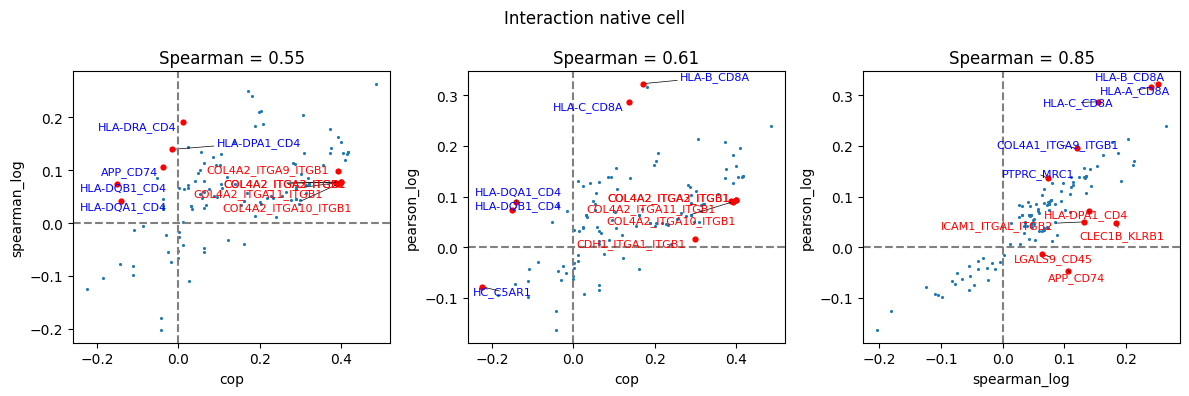

In [371]:
from copulacci import plots2
plots2.draw_pairwise_scatter(
    res.set_index('LR_index'),
    "native cell",
    score_pair,
    bimod_filter=False,
    s = 5,
    ntop=5,
    center_plot=False,
    take_diff=True
    #only_pos=True
)

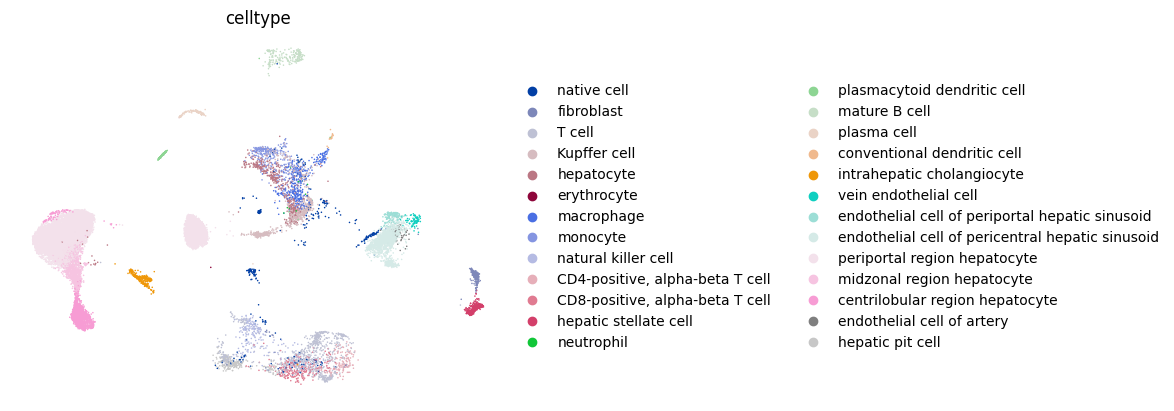

In [392]:
sc.pl.umap(adata, color=["celltype"],frameon=False)

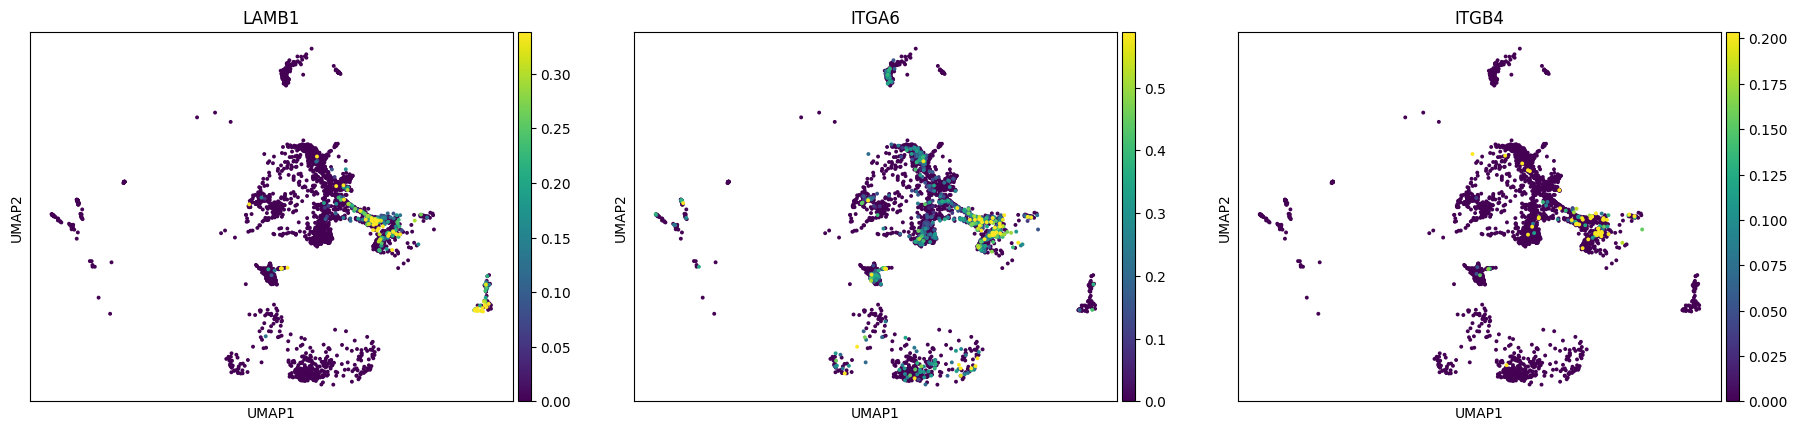

In [600]:
sc.pl.umap(adata_sc[adata_sc.obs.celltype == 'native cell',:], 
           color=["LAMB1", "ITGA6", "ITGB4"],
           use_raw=False,vmax="p99")

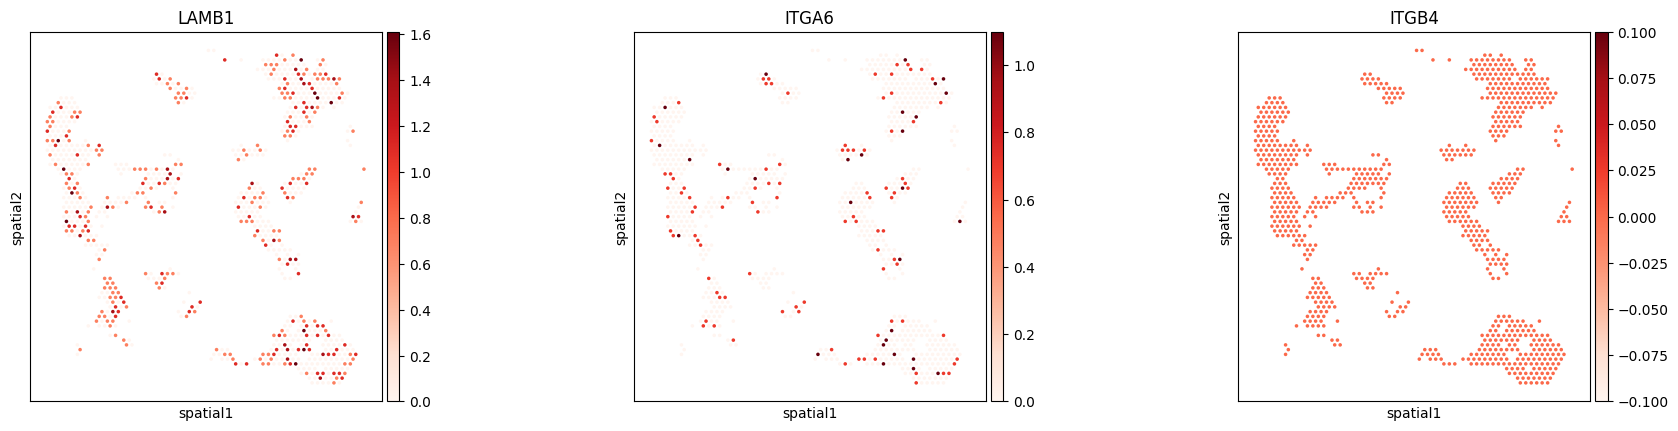

In [605]:
sc.pl.spatial(adata_st[adata_st.obs.celltype == 'native cell',:], 
           color=["LAMB1", "ITGA6", "ITGB4"], cmap = 'Reds', img_key=None,
           use_raw=False,vmax="p99")

In [611]:
adata_st_raw = adata_st.raw.copy()
adata_st_raw.to_adata().var.index = adata_st.var.index 

In [613]:
adata_st_raw.to_adata().var

feature_name feature_reference feature_biotype  \
ENSG00000243485        MIR1302-2HG    NCBITaxon:9606            gene   
ENSG00000237613            FAM138A    NCBITaxon:9606            gene   
ENSG00000186092              OR4F5    NCBITaxon:9606            gene   
ENSG00000238009       RP11-34P13.7    NCBITaxon:9606            gene   
ENSG00000239945       RP11-34P13.8    NCBITaxon:9606            gene   
...                            ...               ...             ...   
ENSG00000277836  ENSG00000277836.1    NCBITaxon:9606            gene   
ENSG00000278633  ENSG00000278633.1    NCBITaxon:9606            gene   
ENSG00000276017  ENSG00000276017.1    NCBITaxon:9606            gene   
ENSG00000278817  ENSG00000278817.1    NCBITaxon:9606            gene   
ENSG00000277196  ENSG00000277196.4    NCBITaxon:9606            gene   

                feature_length  
ENSG00000243485           1021  
ENSG00000237613           1219  
ENSG00000186092           2618  
ENSG00000238009           3726  
ENSG00000239945           1319  
...                        ...  
ENSG00000277836            288  
ENSG00000278633           2404  
ENSG00000276017           2404  
ENSG00000278817           1213  
ENSG00000277196           2405  

[36503 rows x 4 columns]

In [608]:
sc.pl.spatial(adata_st[adata_st.obs.celltype == 'native cell',:], 
           color=["LAMB1", "ITGA6", "ITGB4"], cmap = 'Reds', img_key=None,
           use_raw=True,vmax="p99")

KeyError: 'LAMB1'

<Figure size 2183.4x480 with 0 Axes>